In [1]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Define the hyperparameter search space for XGBoost
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5]
}

In [3]:
pd.set_option('display.max_rows', None)

In [4]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [5]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import label_binarize
from xgboost import XGBClassifier

def train_phase(phase_path, n_iter=10, random_state=42, sample=False):
    best_model = None
    best_score = 0
    all_metrics = []
    best_params = None

    for fold in range(1, 6):
        print(f"\n--- Processing Fold {fold} ---")
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train.columns)

        if fold == 1:
            clf = XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='mlogloss')
            search = RandomizedSearchCV(
                clf,
                param_distributions=param_dist,
                n_iter=n_iter,
                cv=3,
                n_jobs=-1,
                verbose=1,
                scoring='f1_macro'
            )
            search.fit(X_train_scaled, y_train)
            best_params = search.best_params_
            print(f"[Fold 1] Best Parameters Found: {best_params}")

        model = XGBClassifier(**best_params, random_state=random_state, use_label_encoder=False, eval_metric='mlogloss')
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
        y_proba = model.predict_proba(X_val_scaled)

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')

        # AUC Calculation
        classes = model.classes_
        y_val_bin = label_binarize(y_val, classes=classes)
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold

        # Classification report
        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # ROC Curves
        plt.figure(figsize=(8, 6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {cls}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Average Metrics
    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    # Feature Importance
    feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    feature_importances = feature_importances.sort_values(ascending=False)

    print("\nFeature Importances:")
    print(feature_importances)

    return best_model, best_scaler, best_fold, all_metrics



=== Training Phase 1 ===

--- Processing Fold 1 ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.95      0.84      1785
           1       0.67      0.32      0.44       604
           2       0.55      0.28      0.37       258
           3       0.35      0.14      0.20        59
           4       0.17      0.11      0.13         9

    accuracy                           0.73      2715
   macro avg       0.50      0.36      0.40      2715
weighted avg       0.70      0.73      0.69      2715



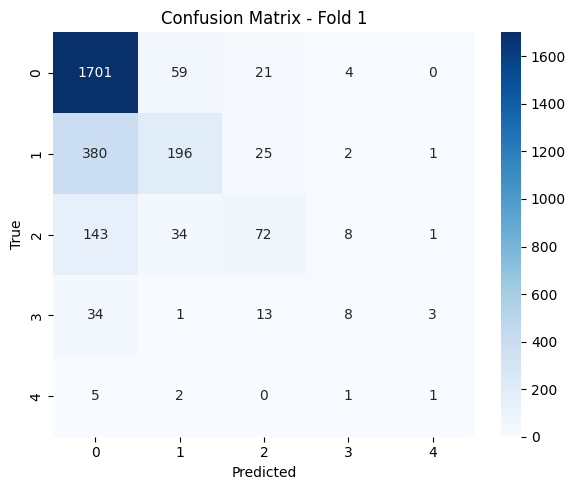

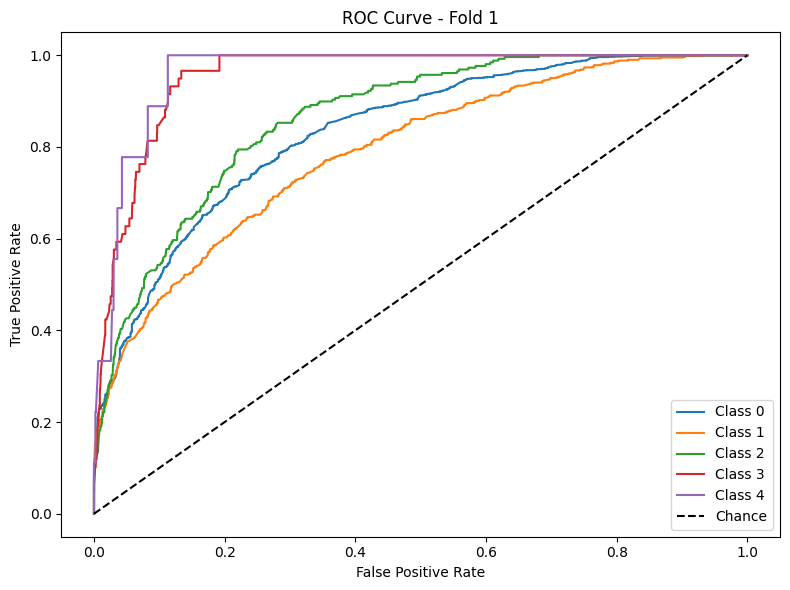


--- Processing Fold 2 ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.95      0.83      1786
           1       0.65      0.29      0.40       603
           2       0.63      0.30      0.41       258
           3       0.32      0.17      0.22        59
           4       0.00      0.00      0.00         8

    accuracy                           0.72      2714
   macro avg       0.47      0.34      0.37      2714
weighted avg       0.70      0.72      0.68      2714



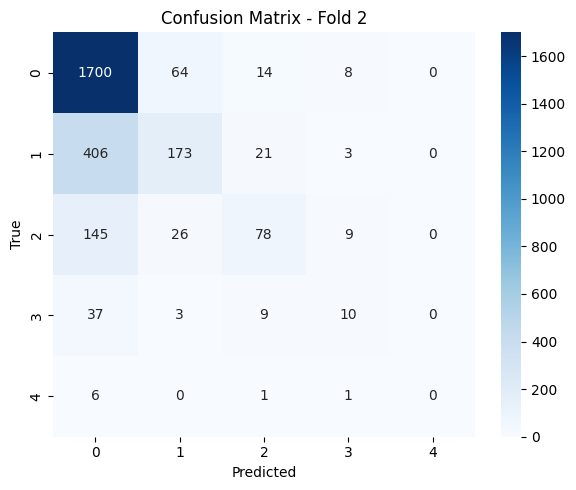

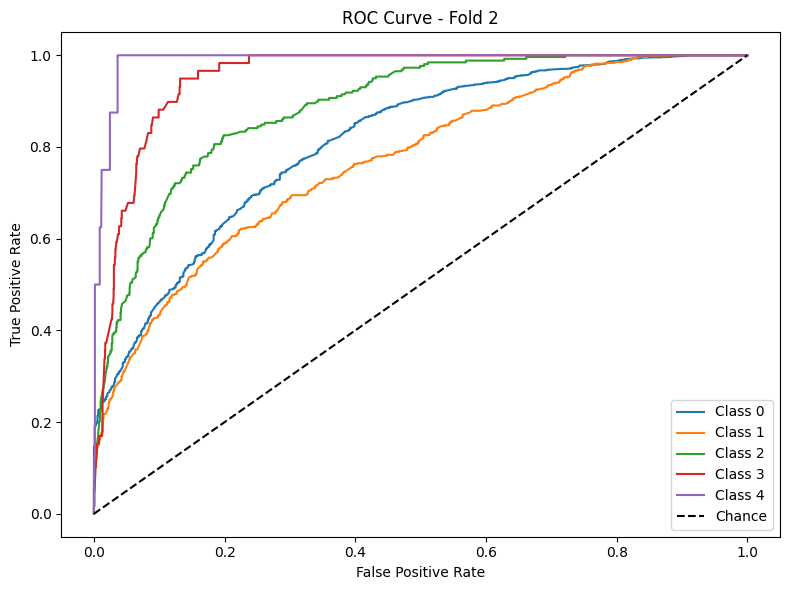


--- Processing Fold 3 ---

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.95      0.84      1786
           1       0.66      0.32      0.43       603
           2       0.58      0.33      0.42       258
           3       0.57      0.27      0.37        59
           4       0.33      0.12      0.18         8

    accuracy                           0.73      2714
   macro avg       0.58      0.40      0.45      2714
weighted avg       0.71      0.73      0.70      2714



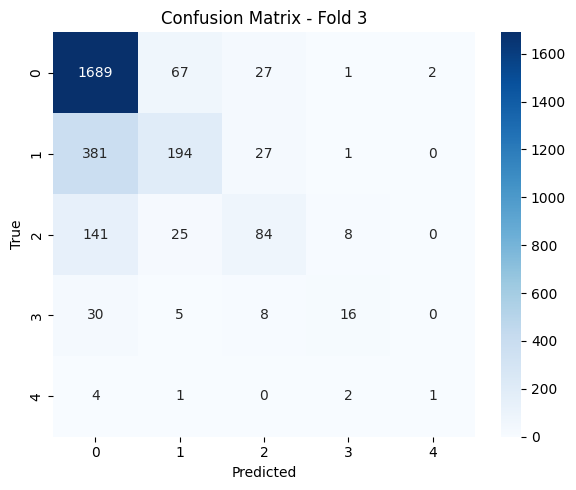

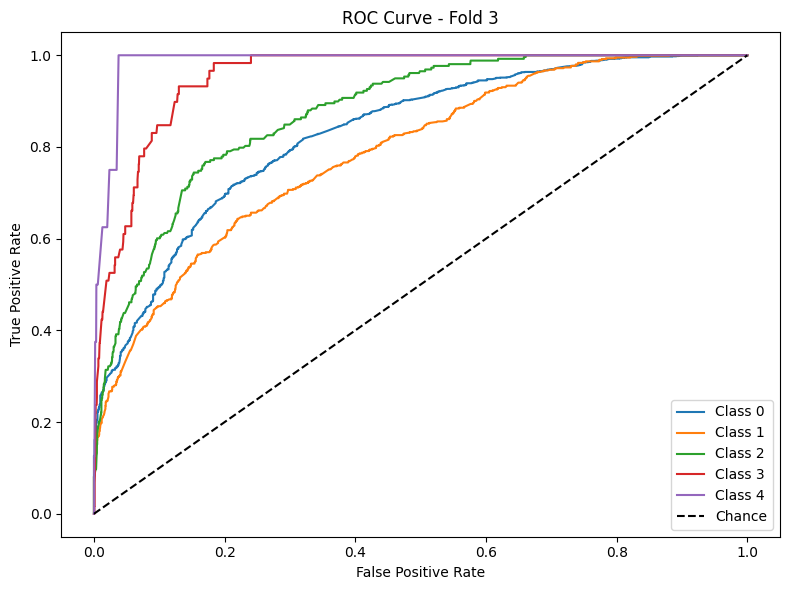


--- Processing Fold 4 ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.96      0.84      1785
           1       0.73      0.33      0.45       603
           2       0.61      0.32      0.42       258
           3       0.41      0.15      0.22        59
           4       0.00      0.00      0.00         9

    accuracy                           0.74      2714
   macro avg       0.50      0.35      0.39      2714
weighted avg       0.72      0.74      0.70      2714



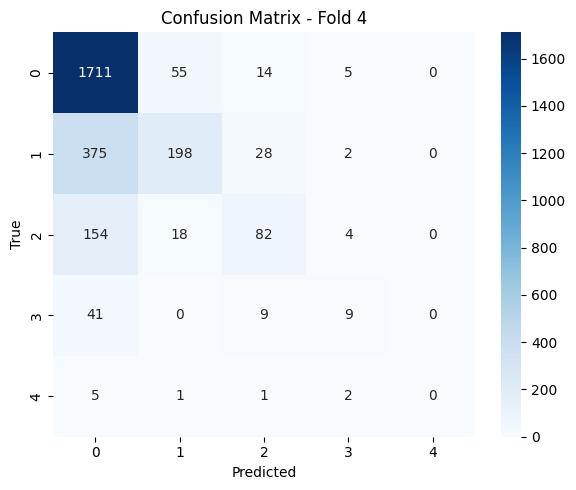

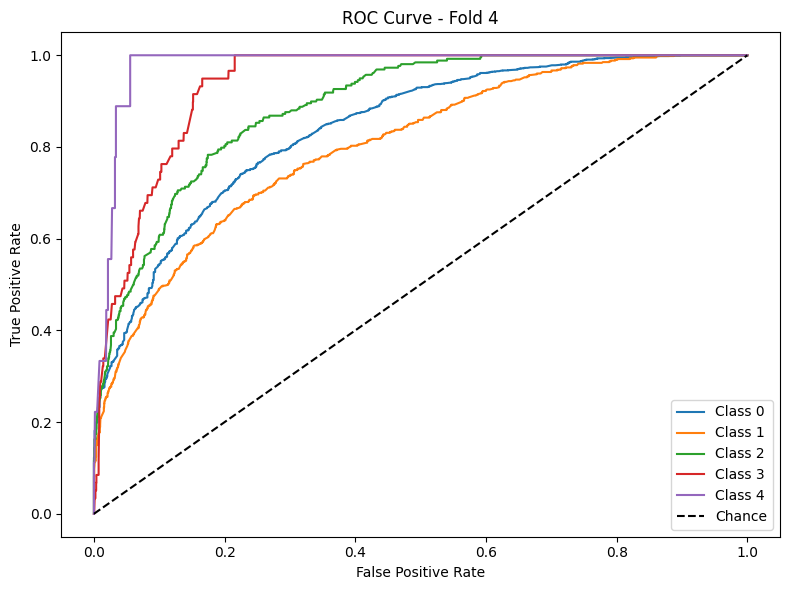


--- Processing Fold 5 ---

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.96      0.84      1785
           1       0.68      0.31      0.42       603
           2       0.57      0.30      0.40       258
           3       0.56      0.17      0.26        59
           4       0.50      0.11      0.18         9

    accuracy                           0.73      2714
   macro avg       0.61      0.37      0.42      2714
weighted avg       0.71      0.73      0.69      2714



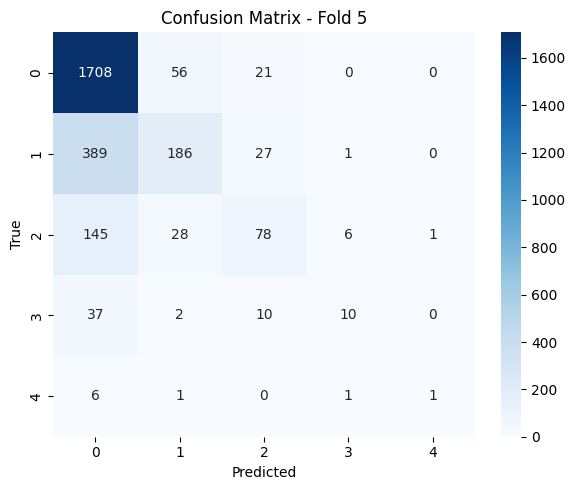

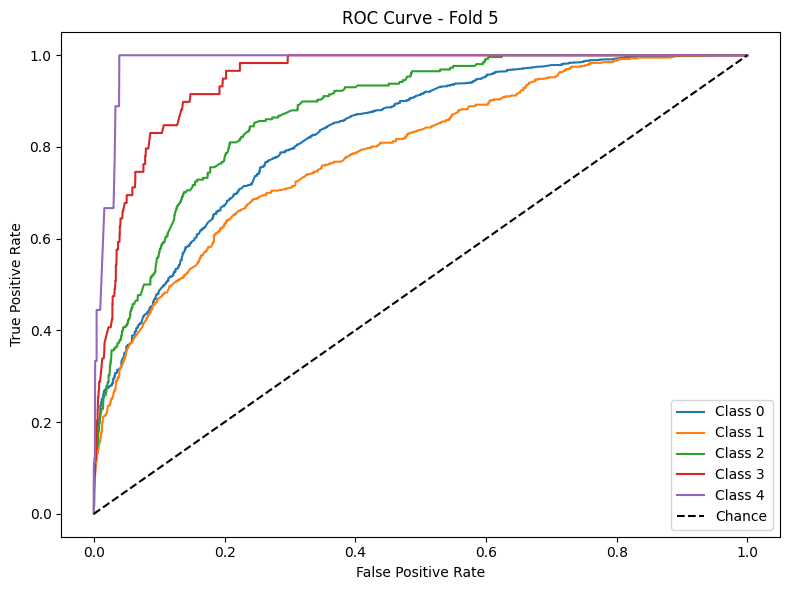


Average Accuracy: 0.7299
Average F1 Macro: 0.4045
Average AUC: 0.8847

Feature Importances:
video                                  0.082785
assignment                             0.074596
certificate                            0.052387
exercise_num_problem_sum_1             0.050241
exercise_perc_real_score_mean_1        0.049132
exercise_correct_sum_1                 0.044930
exercise_id_count_1                    0.043299
end_year                               0.041627
encoded_field_sum                      0.040546
num_prerequisites                      0.040373
duration_days                          0.039369
exercise_count                         0.037861
exercise_context_sum_1                 0.036393
chapter_count                          0.034421
video_count                            0.033445
school                                 0.032881
exercise_correct_mean_1                0.031220
exercise_langugage_binary_mean_1       0.025316
exam                                   0.02

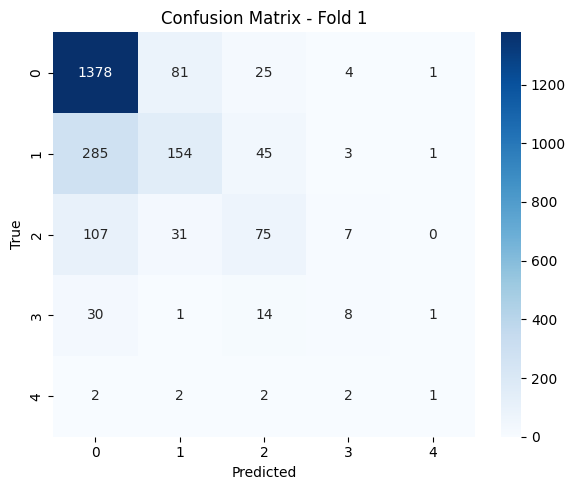

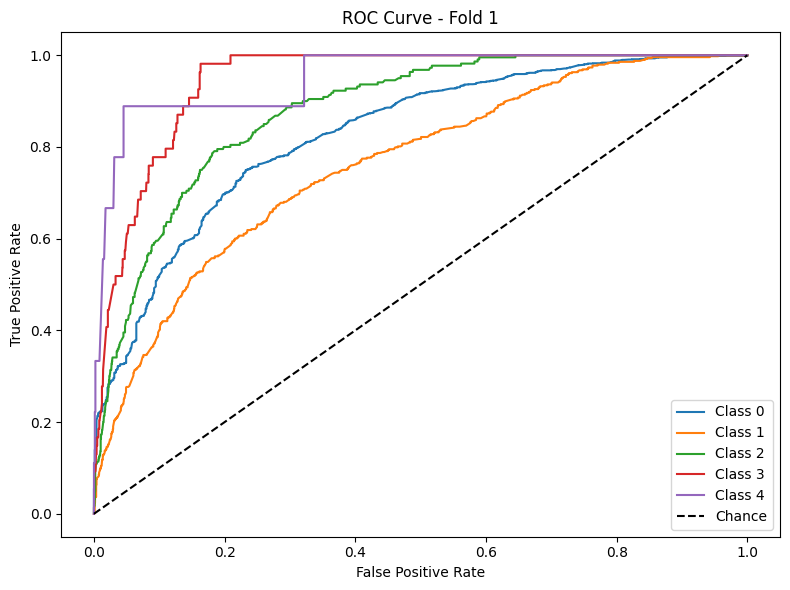


--- Processing Fold 2 ---

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.93      0.84      1489
           1       0.58      0.29      0.39       489
           2       0.46      0.34      0.39       219
           3       0.35      0.20      0.26        55
           4       0.00      0.00      0.00         8

    accuracy                           0.71      2260
   macro avg       0.43      0.35      0.37      2260
weighted avg       0.68      0.71      0.68      2260



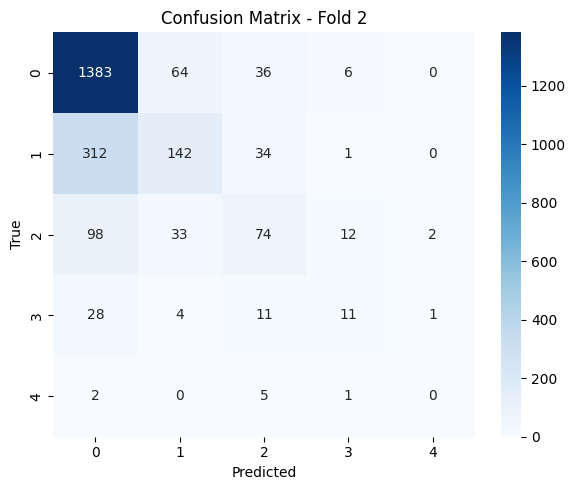

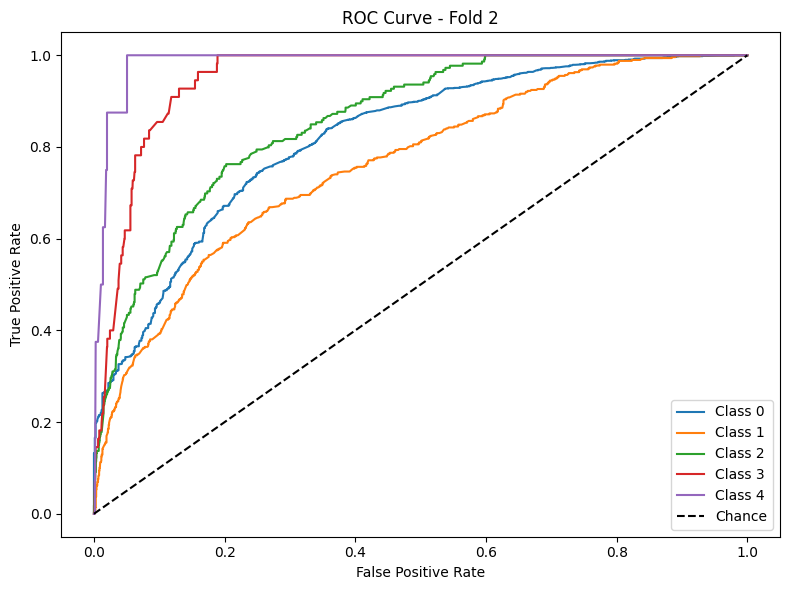


--- Processing Fold 3 ---

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.93      0.84      1489
           1       0.57      0.30      0.39       489
           2       0.49      0.39      0.43       219
           3       0.25      0.15      0.19        54
           4       1.00      0.12      0.22         8

    accuracy                           0.72      2259
   macro avg       0.62      0.38      0.41      2259
weighted avg       0.69      0.72      0.69      2259



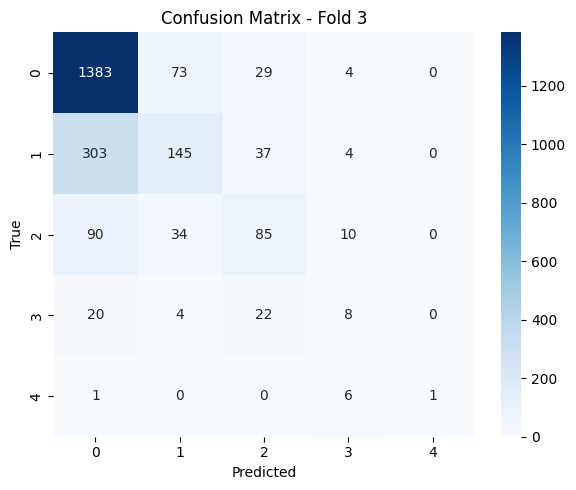

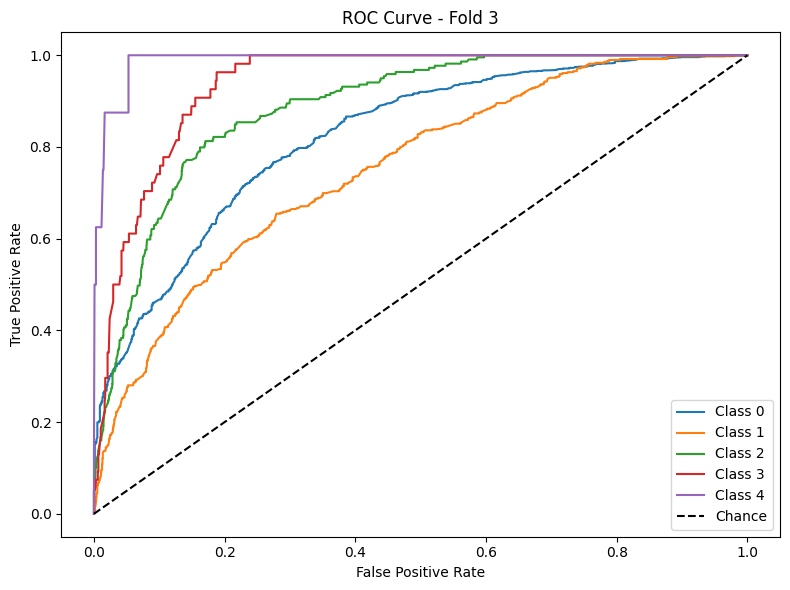


--- Processing Fold 4 ---

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.92      0.83      1489
           1       0.58      0.30      0.40       489
           2       0.51      0.37      0.42       219
           3       0.32      0.19      0.24        54
           4       0.43      0.38      0.40         8

    accuracy                           0.71      2259
   macro avg       0.52      0.43      0.46      2259
weighted avg       0.68      0.71      0.68      2259



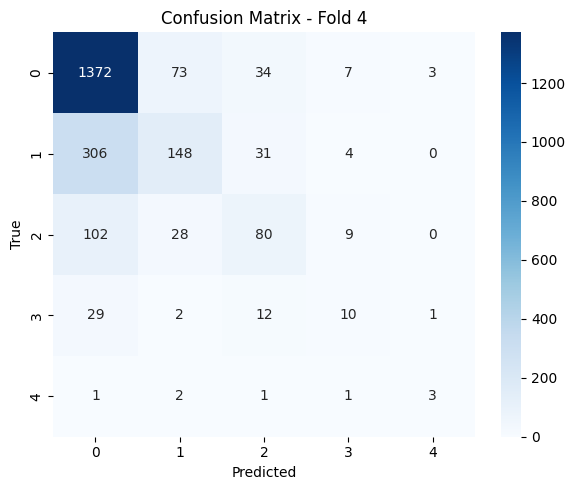

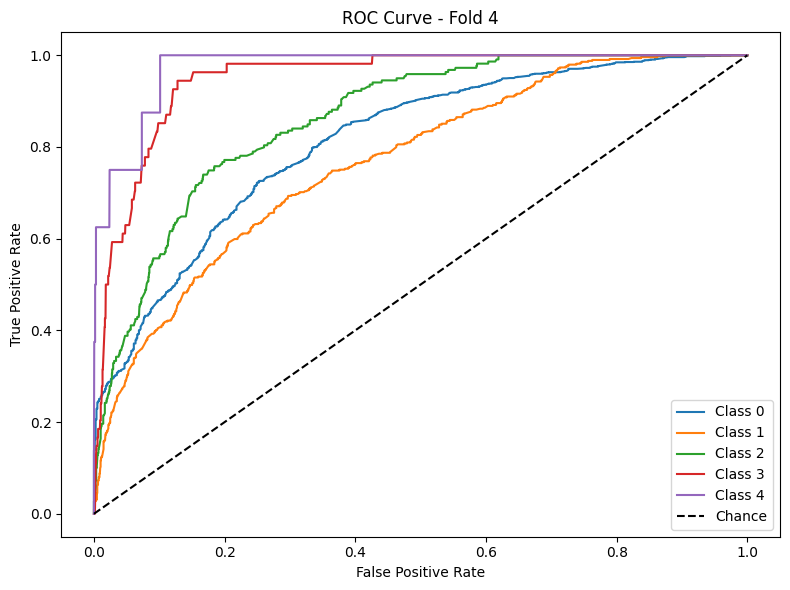


--- Processing Fold 5 ---

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.93      0.85      1490
           1       0.60      0.36      0.45       488
           2       0.47      0.37      0.42       219
           3       0.21      0.11      0.15        54
           4       0.20      0.12      0.15         8

    accuracy                           0.73      2259
   macro avg       0.45      0.38      0.40      2259
weighted avg       0.70      0.73      0.70      2259



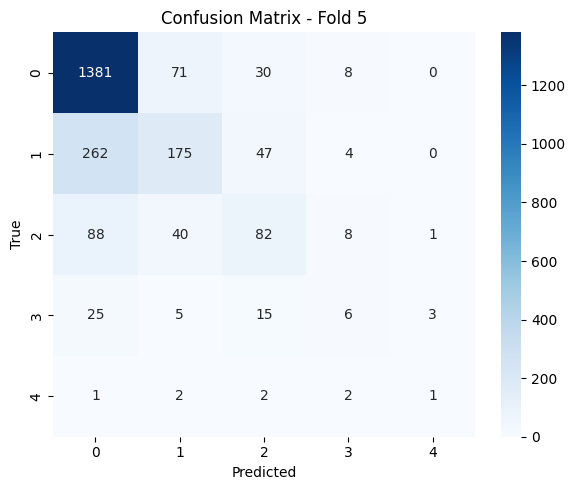

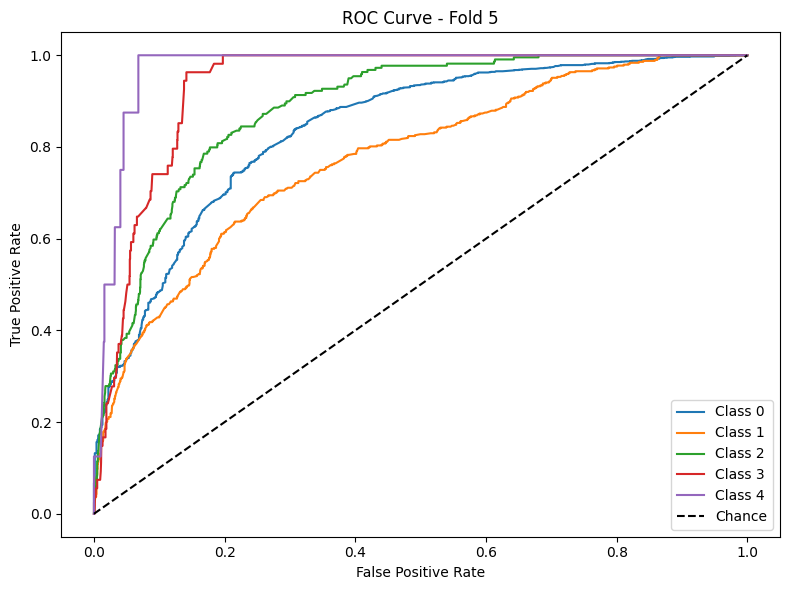


Average Accuracy: 0.7175
Average F1 Macro: 0.4098
Average AUC: 0.8762

Feature Importances:
video                                  0.063225
assignment                             0.035878
exercise_context_sum_1                 0.035610
certificate                            0.033259
exercise_correct_sum_2                 0.032966
exercise_perc_real_score_mean_2        0.031555
exercise_count                         0.029949
encoded_field_sum                      0.029666
exercise_correct_sum_1                 0.029531
num_prerequisites                      0.028793
duration_days                          0.028329
exercise_correct_mean_2                0.028014
exercise_num_problem_sum_1             0.026574
video_count                            0.024895
exercise_perc_real_score_mean_1        0.022567
exercise_context_sum_2                 0.022327
exam                                   0.021859
chapter_count                          0.021577
exercise_id_count_1                    0.02

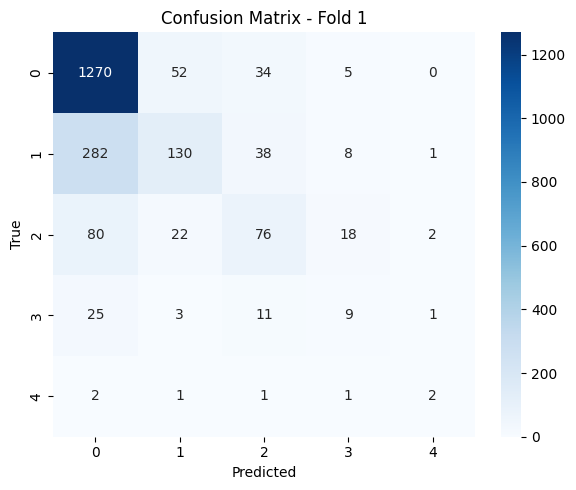

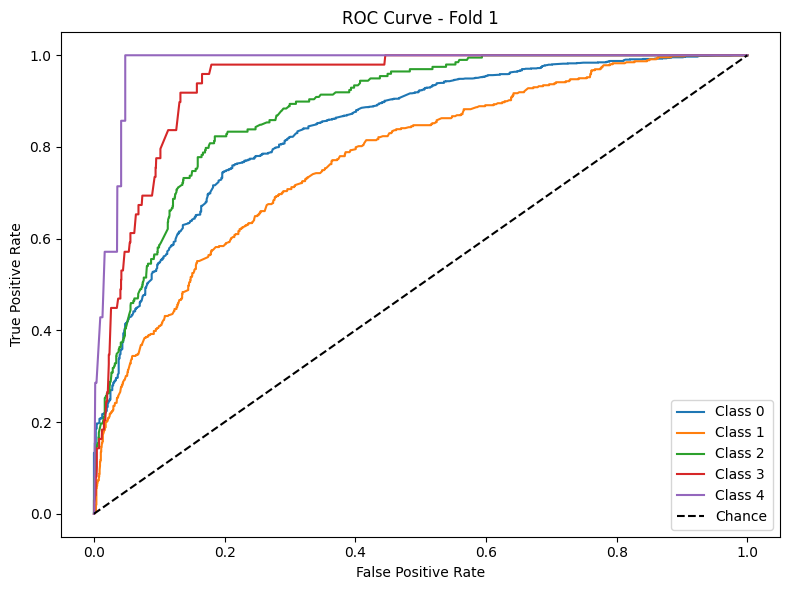


--- Processing Fold 2 ---

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84      1360
           1       0.58      0.35      0.44       459
           2       0.52      0.43      0.47       198
           3       0.41      0.14      0.21        50
           4       0.00      0.00      0.00         7

    accuracy                           0.72      2074
   macro avg       0.46      0.37      0.39      2074
weighted avg       0.70      0.72      0.70      2074



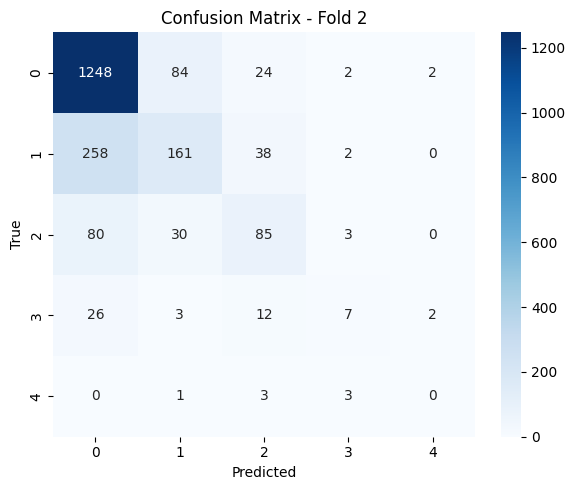

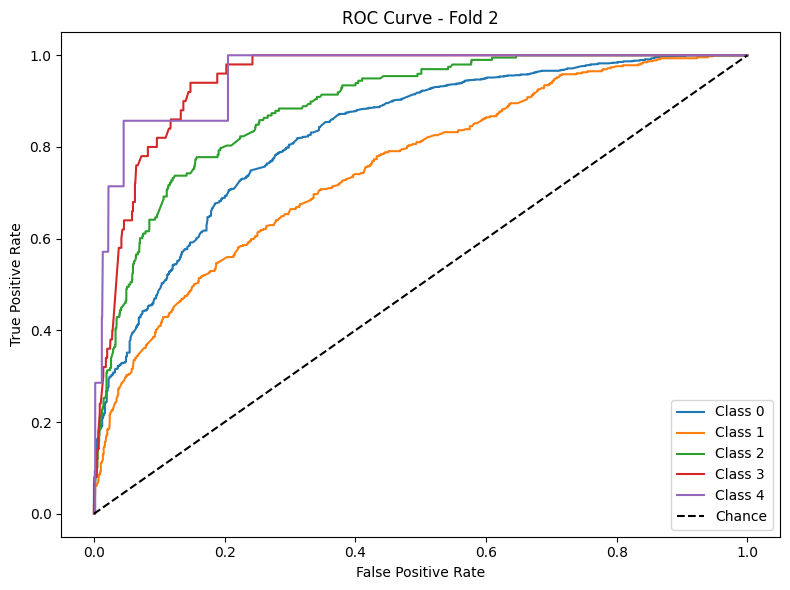


--- Processing Fold 3 ---

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84      1360
           1       0.55      0.32      0.41       459
           2       0.48      0.38      0.43       198
           3       0.46      0.24      0.32        50
           4       0.50      0.29      0.36         7

    accuracy                           0.72      2074
   macro avg       0.55      0.43      0.47      2074
weighted avg       0.69      0.72      0.69      2074



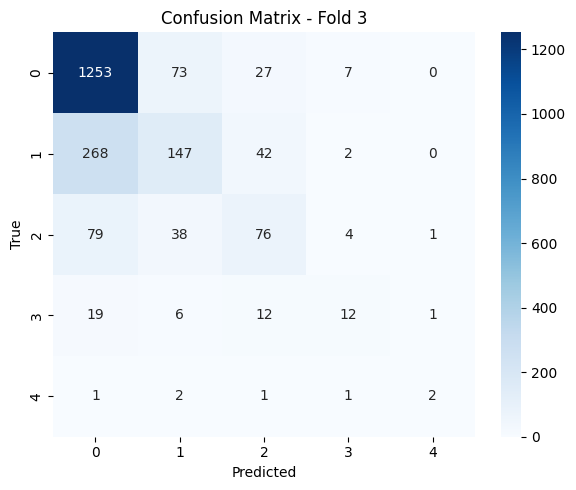

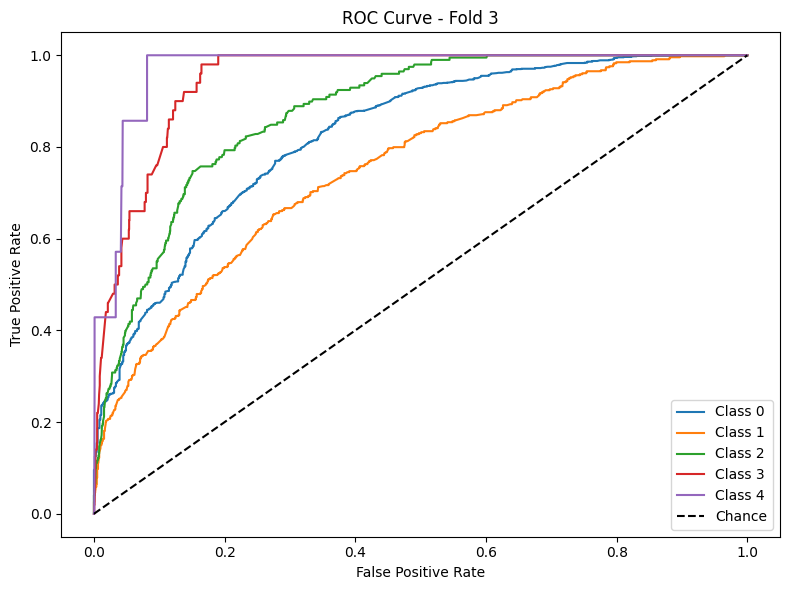


--- Processing Fold 4 ---

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.93      0.83      1360
           1       0.56      0.30      0.39       459
           2       0.50      0.36      0.42       198
           3       0.41      0.18      0.25        50
           4       0.50      0.29      0.36         7

    accuracy                           0.71      2074
   macro avg       0.55      0.41      0.45      2074
weighted avg       0.68      0.71      0.68      2074



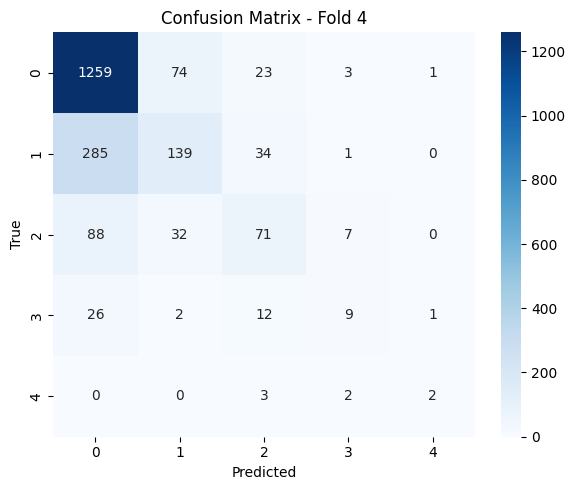

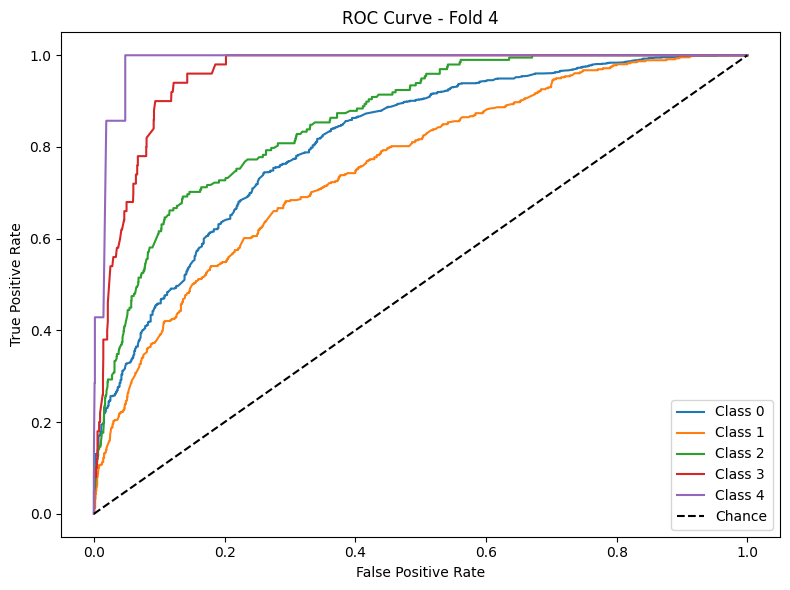


--- Processing Fold 5 ---

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.92      0.83      1360
           1       0.56      0.30      0.40       460
           2       0.49      0.40      0.44       197
           3       0.41      0.22      0.29        49
           4       0.12      0.14      0.13         7

    accuracy                           0.71      2073
   macro avg       0.47      0.40      0.42      2073
weighted avg       0.68      0.71      0.68      2073



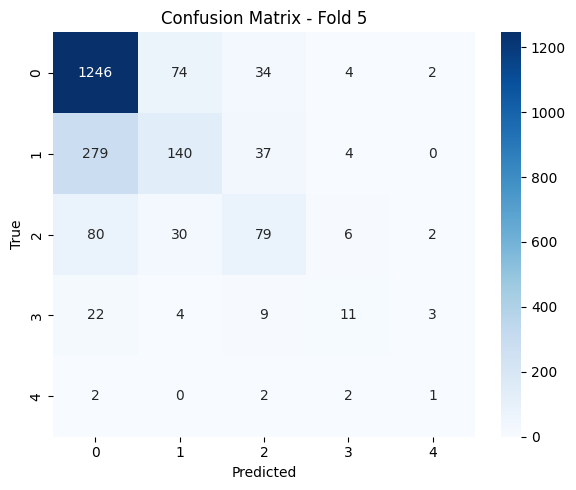

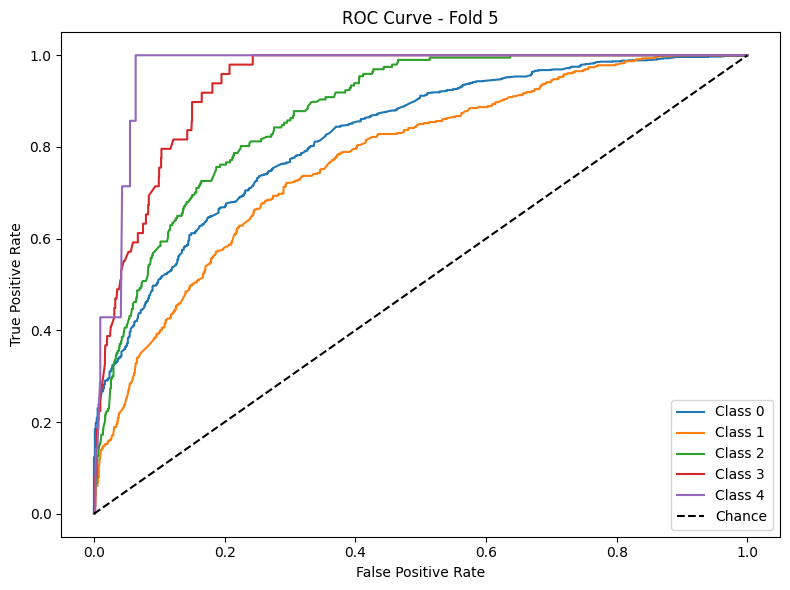


Average Accuracy: 0.7170
Average F1 Macro: 0.4330
Average AUC: 0.8765

Feature Importances:
video                                  0.059970
assignment                             0.037951
exercise_context_sum_1                 0.037077
certificate                            0.034063
exercise_context_sum_3                 0.028165
duration_days                          0.027818
num_prerequisites                      0.027125
encoded_field_sum                      0.024225
exercise_correct_sum_1                 0.022935
exercise_count                         0.022203
exercise_context_sum_2                 0.022060
exercise_perc_real_score_mean_2        0.021105
video_count                            0.020274
exercise_correct_sum_3                 0.019733
exercise_id_count_1                    0.019705
chapter_count                          0.018980
exercise_perc_real_score_mean_3        0.018197
exercise_num_problem_sum_1             0.018173
exercise_correct_sum_2                 0.01

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.93      0.84      1000
           1       0.68      0.37      0.48       355
           2       0.50      0.37      0.42       139
           3       0.41      0.28      0.33        39
           4       0.00      0.00      0.00         6

    accuracy                           0.73      1539
   macro avg       0.47      0.39      0.42      1539
weighted avg       0.71      0.73      0.70      1539



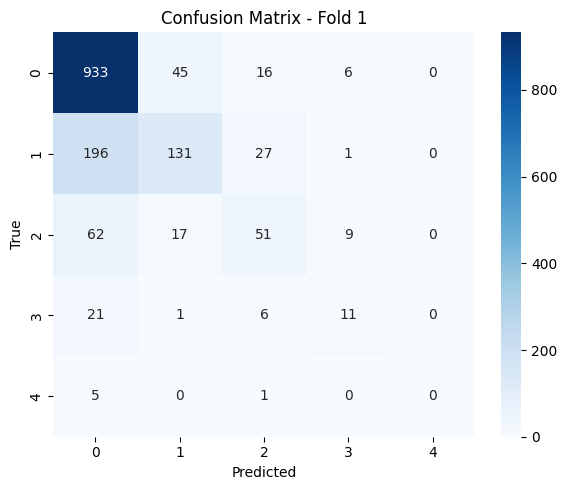

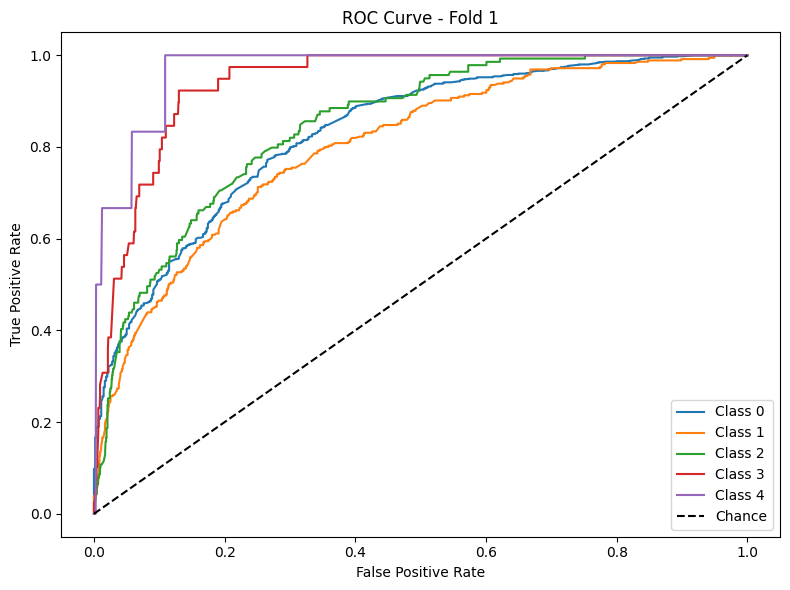


--- Processing Fold 2 ---

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.94      0.84      1000
           1       0.62      0.36      0.45       355
           2       0.57      0.37      0.45       139
           3       0.43      0.15      0.22        40
           4       0.00      0.00      0.00         5

    accuracy                           0.73      1539
   macro avg       0.48      0.36      0.39      1539
weighted avg       0.70      0.73      0.70      1539



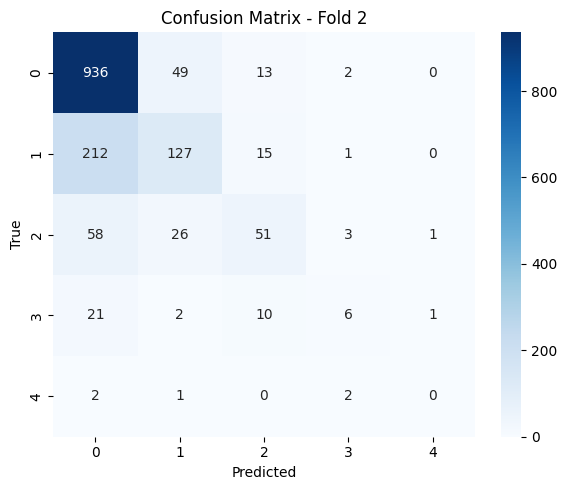

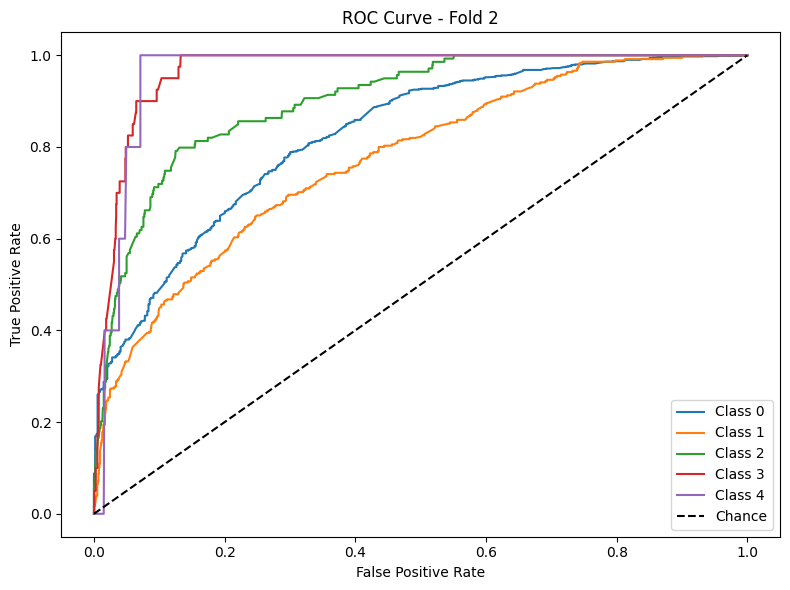


--- Processing Fold 3 ---

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.94      0.85       999
           1       0.65      0.37      0.47       355
           2       0.57      0.37      0.45       139
           3       0.43      0.23      0.30        40
           4       0.00      0.00      0.00         6

    accuracy                           0.74      1539
   macro avg       0.48      0.38      0.41      1539
weighted avg       0.71      0.74      0.71      1539



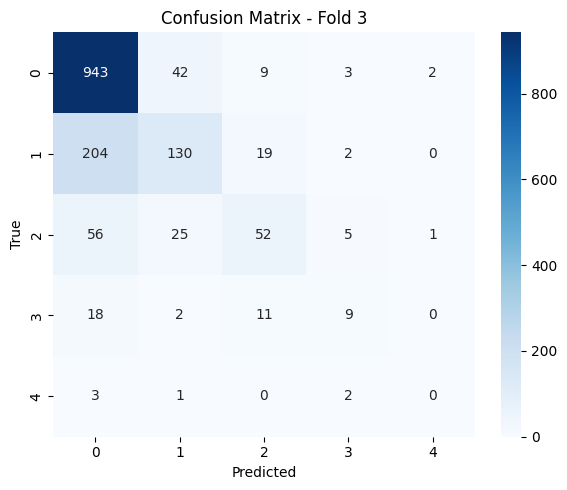

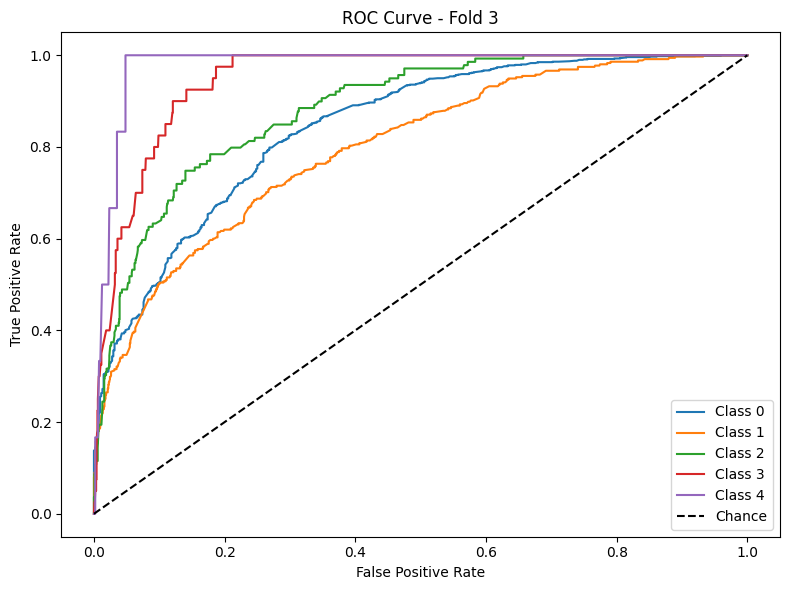


--- Processing Fold 4 ---

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.95      0.85       999
           1       0.67      0.35      0.46       356
           2       0.50      0.34      0.41       138
           3       0.19      0.08      0.11        39
           4       0.00      0.00      0.00         6

    accuracy                           0.73      1538
   macro avg       0.42      0.34      0.36      1538
weighted avg       0.70      0.73      0.70      1538



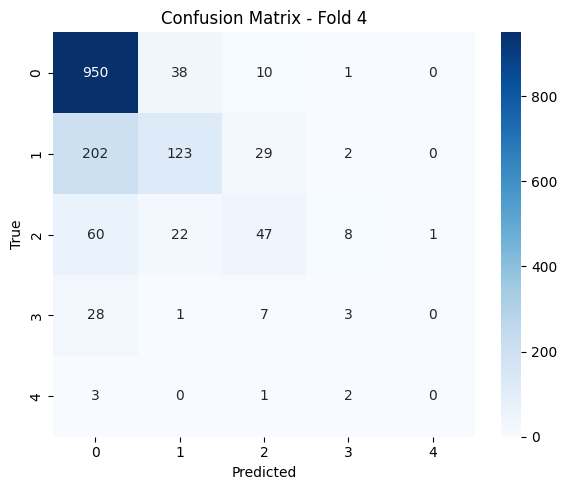

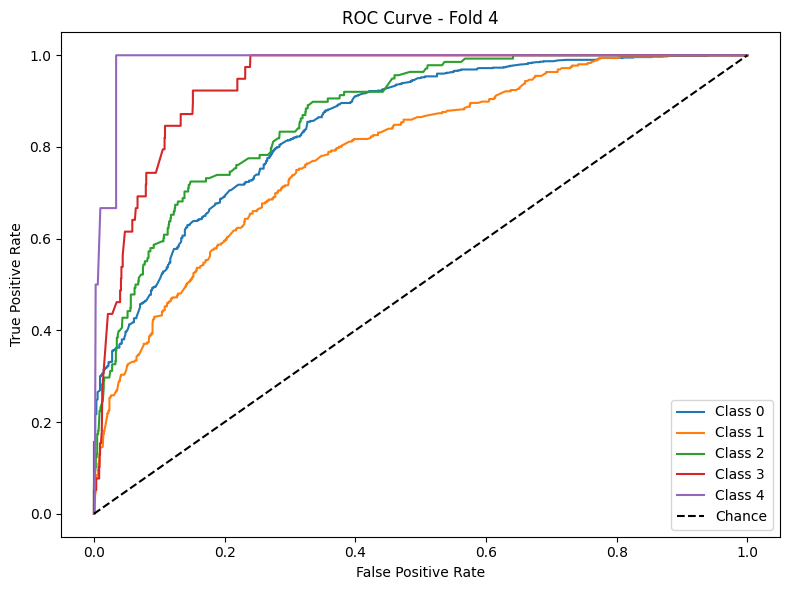


--- Processing Fold 5 ---

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.92      0.84       999
           1       0.61      0.40      0.48       356
           2       0.49      0.33      0.40       138
           3       0.46      0.28      0.35        39
           4       0.00      0.00      0.00         6

    accuracy                           0.73      1538
   macro avg       0.47      0.39      0.41      1538
weighted avg       0.70      0.73      0.70      1538



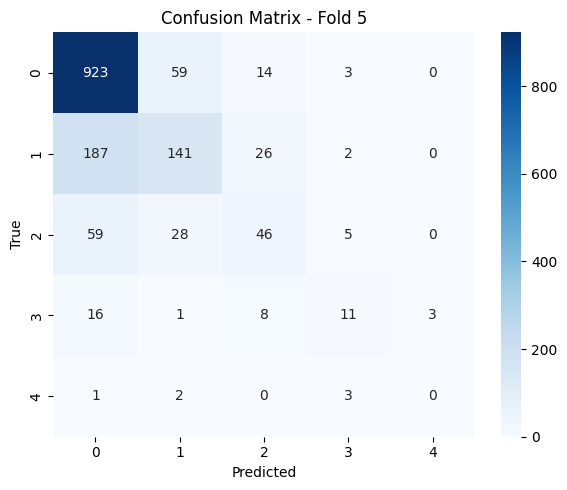

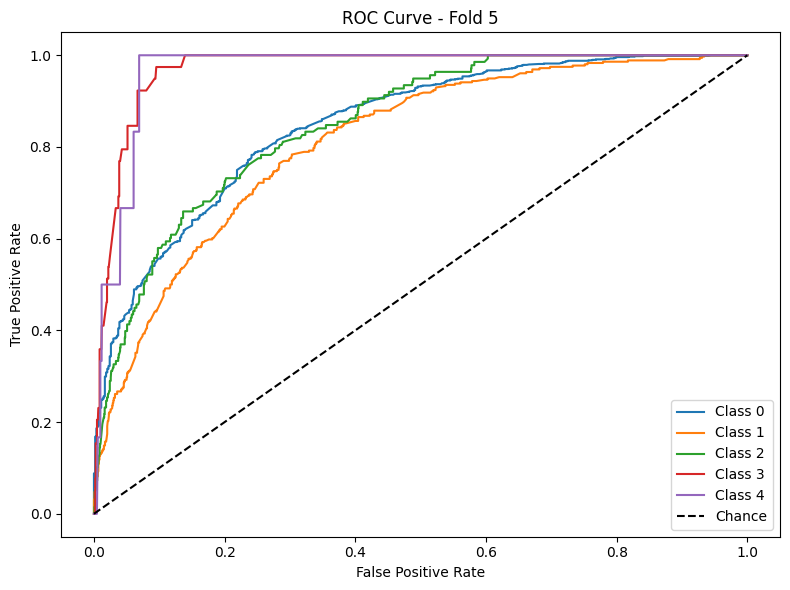


Average Accuracy: 0.7311
Average F1 Macro: 0.3997
Average AUC: 0.8863

Feature Importances:
exercise_perc_real_completed_mean_1    0.052655
video                                  0.035577
assignment                             0.035326
video_count                            0.032803
exercise_count                         0.027921
exercise_num_problem_sum_1             0.027500
duration_days                          0.027493
num_prerequisites                      0.025084
exercise_context_sum_3                 0.023886
exercise_context_sum_4                 0.023145
exercise_context_sum_1                 0.022146
exercise_correct_sum_4                 0.021760
school                                 0.021596
exercise_correct_sum_1                 0.021458
exercise_perc_real_score_mean_2        0.019675
user_time_since_last_course            0.019371
exercise_correct_mean_2                0.019267
exercise_num_problem_sum_4             0.019199
certificate                            0.01

In [6]:
phase_paths = [f"/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics


## Predict on Test Data

In [7]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

def predict_on_test(test_file_path, model_file, scaler_file, school_mapping_file):
    # Load model, scaler, and mapping
    model = joblib.load(model_file)
    scaler = joblib.load(scaler_file)
    mapping = joblib.load(school_mapping_file)

    # Load and preprocess test data
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded']
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    # Apply school mapping
    if 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    # Scale features
    X_test_scaled = scaler.transform(X_test)

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score
    classes = model.classes_
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       568
           1       0.59      0.27      0.37        63
           2       0.43      0.21      0.28        43
           3       0.00      0.00      0.00        15
           4       1.00      0.22      0.36         9

    accuracy                           0.84       698
   macro avg       0.58      0.34      0.39       698
weighted avg       0.80      0.84      0.81       698



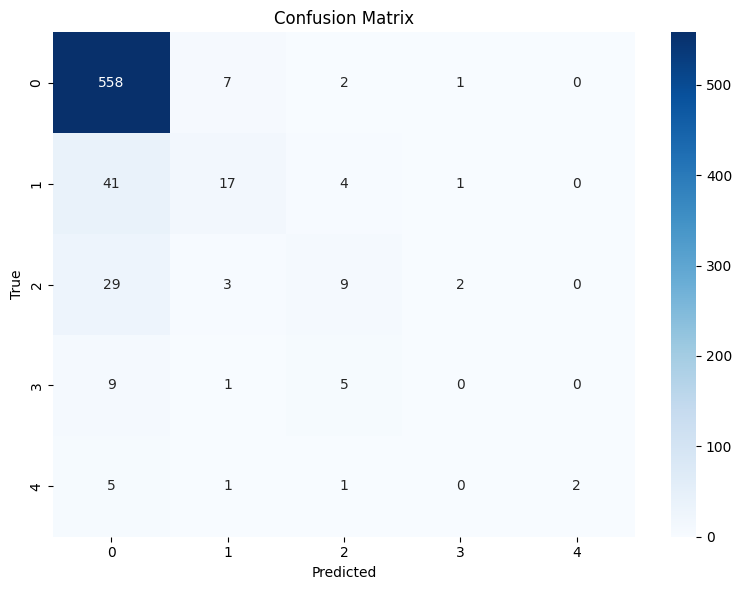


Test AUC (macro-average, OVR): 0.8784


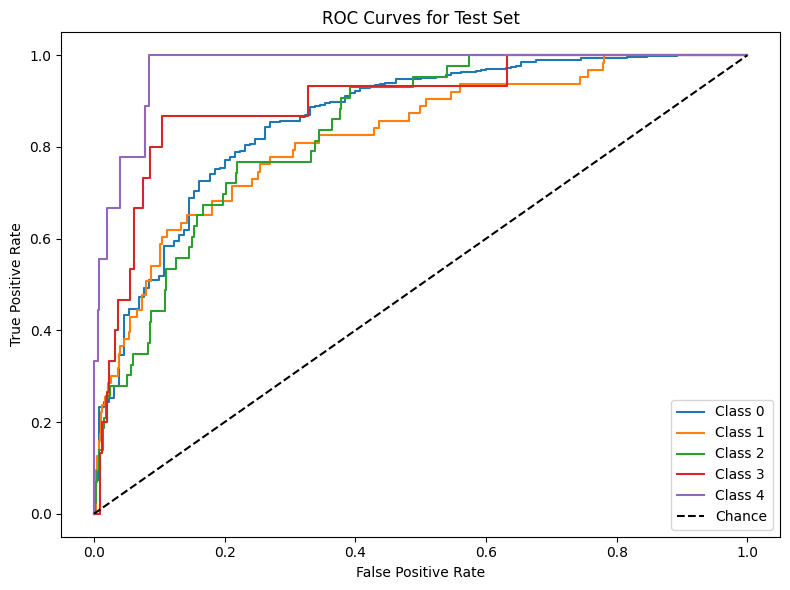


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       544
           1       0.32      0.20      0.25        59
           2       0.36      0.21      0.27        42
           3       0.50      0.07      0.12        14
           4       0.00      0.00      0.00         9

    accuracy                           0.82       668
   macro avg       0.41      0.29      0.31       668
weighted avg       0.77      0.82      0.79       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


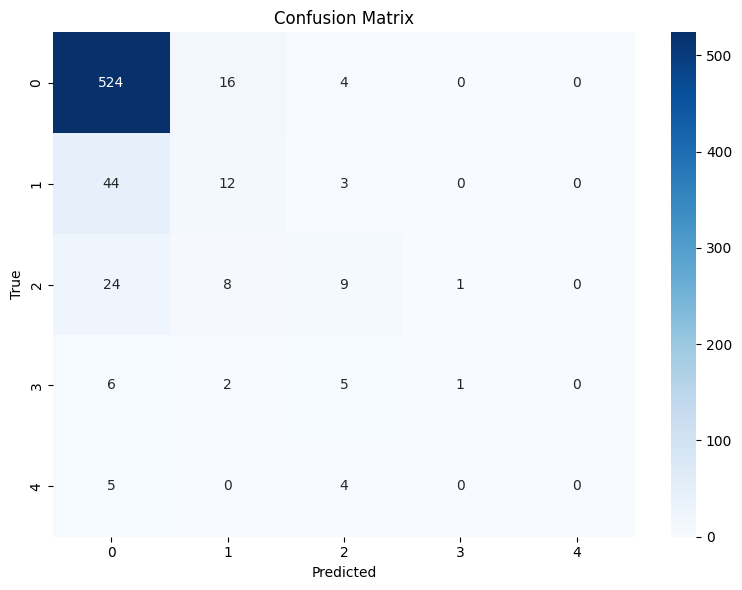


Test AUC (macro-average, OVR): 0.8623


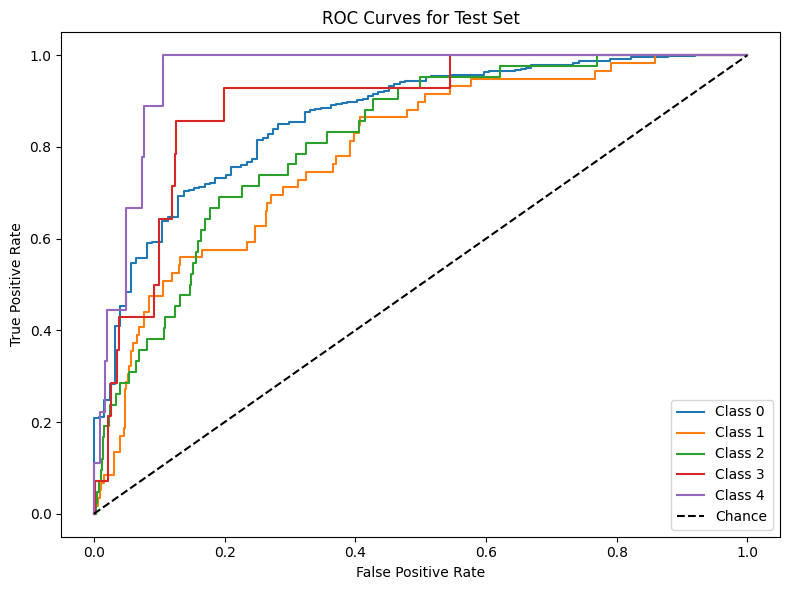


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       455
           1       0.36      0.10      0.15        52
           2       0.26      0.17      0.21        29
           3       0.00      0.00      0.00        10
           4       1.00      0.12      0.22         8

    accuracy                           0.83       554
   macro avg       0.50      0.28      0.30       554
weighted avg       0.77      0.83      0.78       554



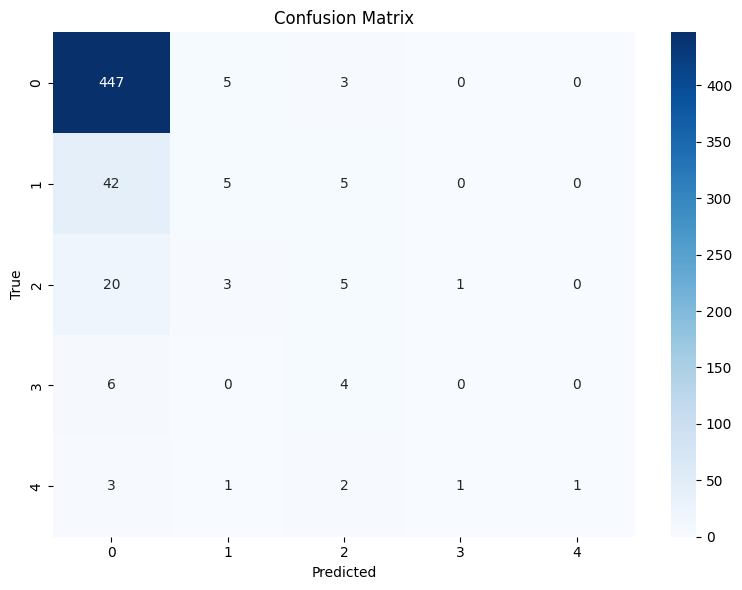


Test AUC (macro-average, OVR): 0.8353


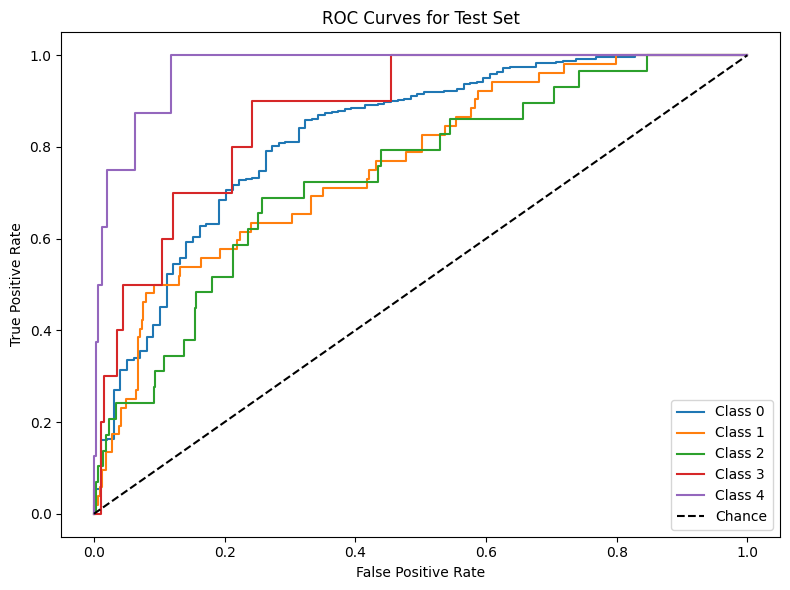


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       395
           1       0.15      0.10      0.12        40
           2       0.32      0.33      0.33        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.81       477
   macro avg       0.27      0.28      0.27       477
weighted avg       0.75      0.81      0.78       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


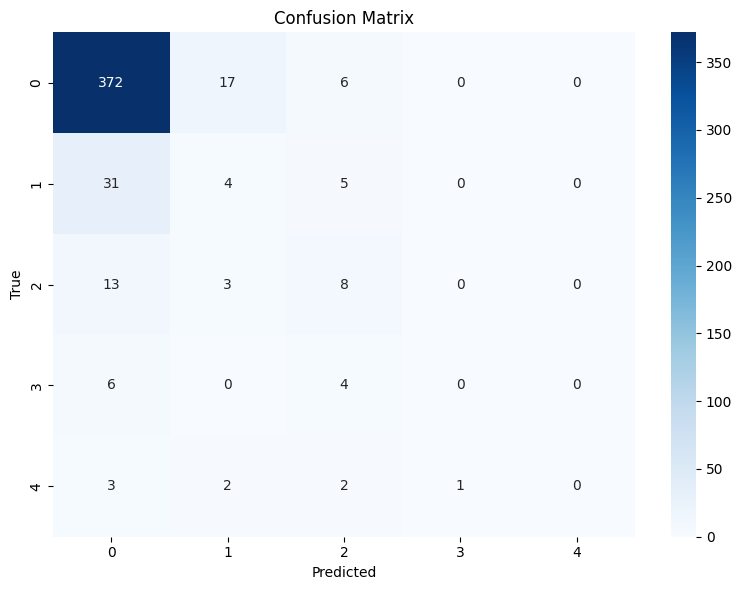


Test AUC (macro-average, OVR): 0.7931


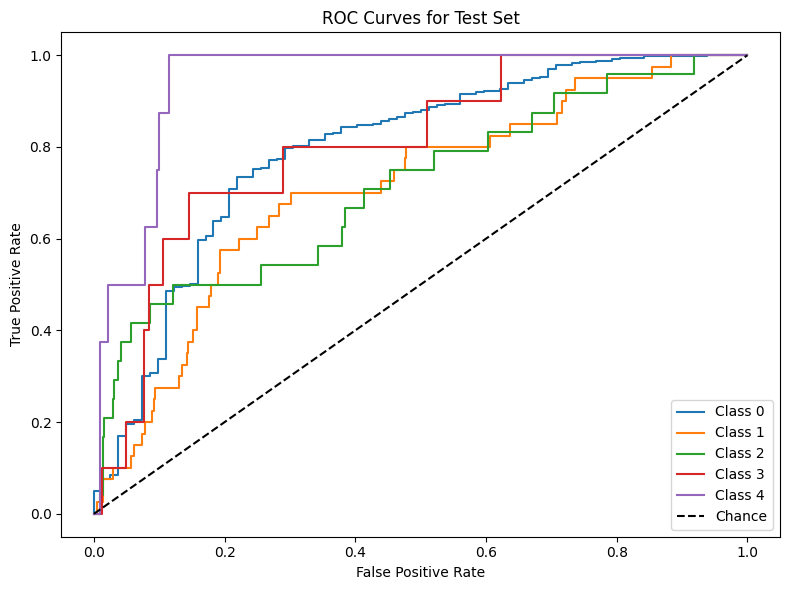

In [8]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/filtered-final-data/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)


# Sample


=== Training Phase 1 ===

--- Processing Fold 1 ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 1.0}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81      1785
           1       0.52      0.48      0.50       604
           2       0.38      0.50      0.43       258
           3       0.23      0.42      0.29        59
           4       0.07      0.11      0.09         9

    accuracy                           0.68      2715
   macro avg       0.41      0.46      0.42      2715
weighted avg       0.70      0.68      0.69      2715



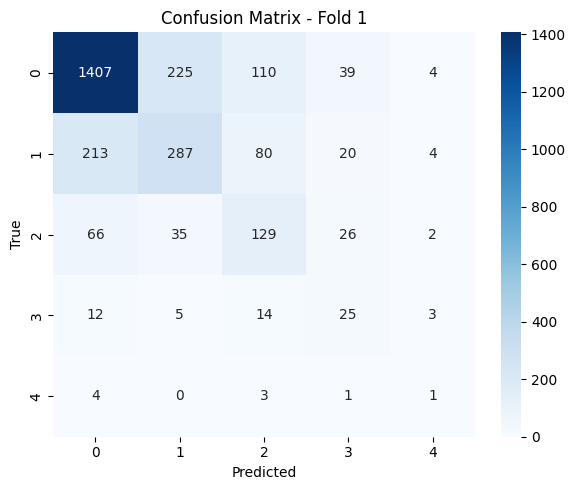

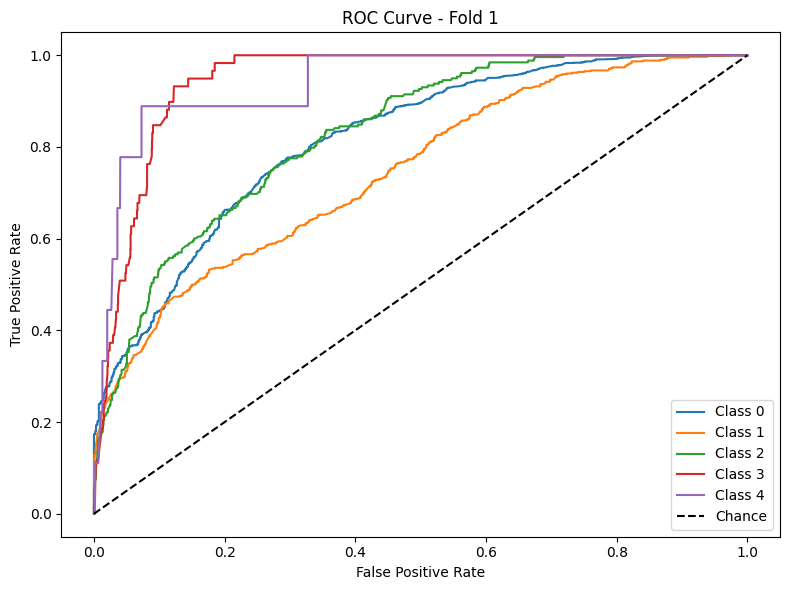


--- Processing Fold 2 ---

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.77      0.79      1786
           1       0.49      0.48      0.48       603
           2       0.41      0.47      0.44       258
           3       0.22      0.56      0.31        59
           4       0.10      0.12      0.11         8

    accuracy                           0.67      2714
   macro avg       0.41      0.48      0.43      2714
weighted avg       0.69      0.67      0.68      2714



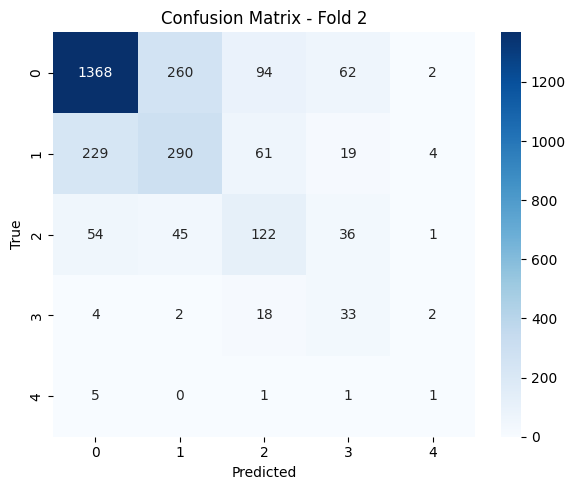

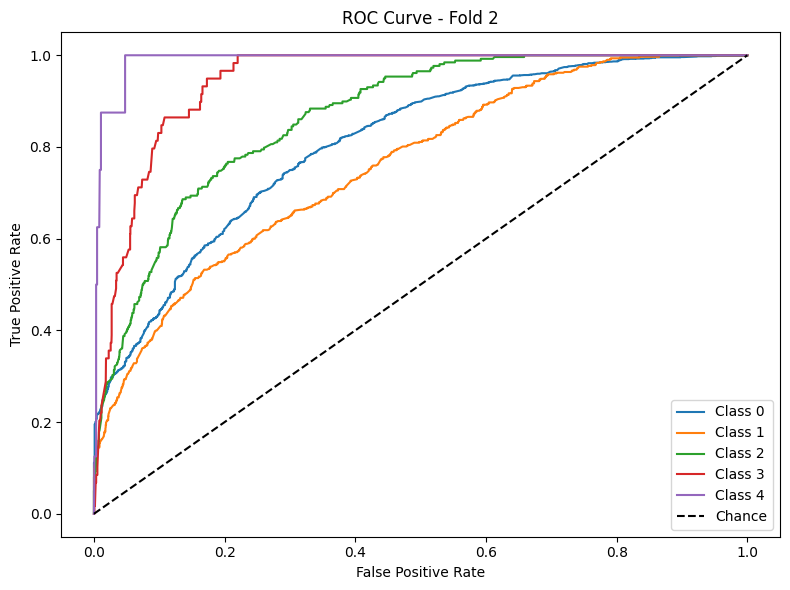


--- Processing Fold 3 ---

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.76      0.79      1786
           1       0.49      0.49      0.49       603
           2       0.39      0.55      0.45       258
           3       0.25      0.42      0.32        59
           4       0.33      0.38      0.35         8

    accuracy                           0.67      2714
   macro avg       0.46      0.52      0.48      2714
weighted avg       0.70      0.67      0.68      2714



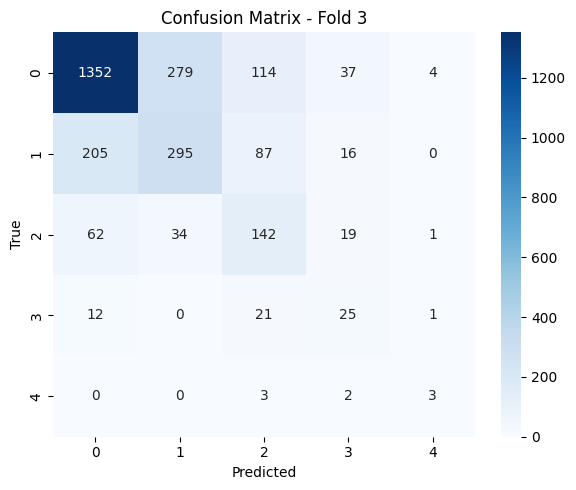

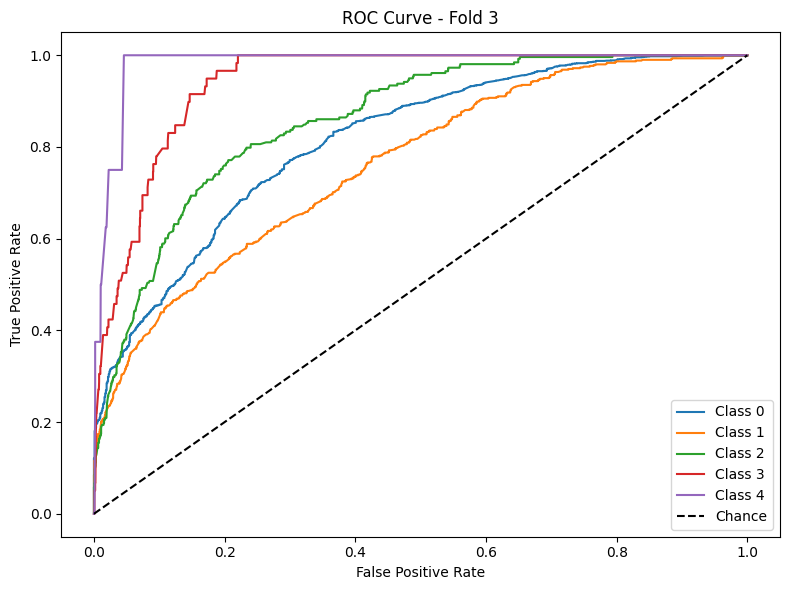


--- Processing Fold 4 ---

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.77      0.80      1785
           1       0.49      0.52      0.50       603
           2       0.39      0.49      0.43       258
           3       0.19      0.31      0.24        59
           4       0.08      0.11      0.09         9

    accuracy                           0.67      2714
   macro avg       0.40      0.44      0.41      2714
weighted avg       0.70      0.67      0.68      2714



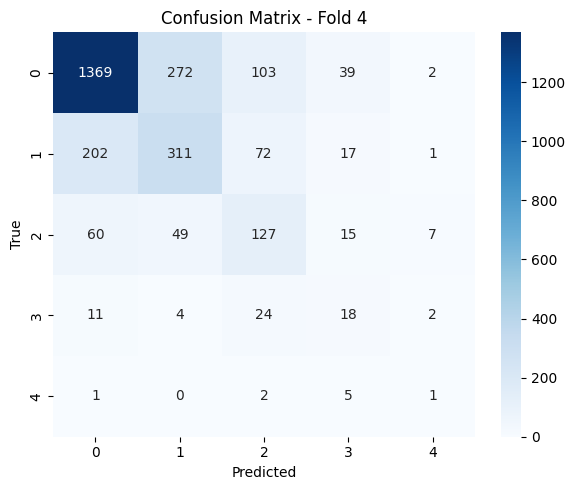

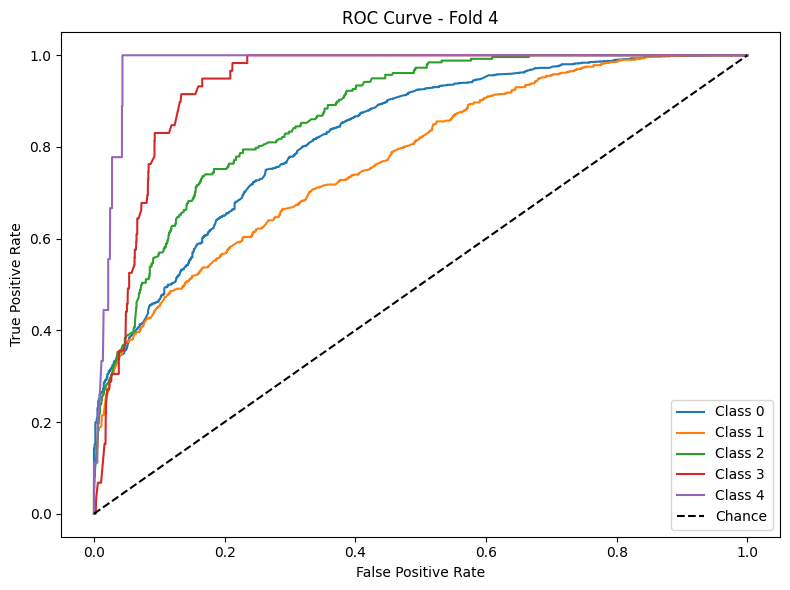


--- Processing Fold 5 ---

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81      1785
           1       0.52      0.50      0.51       603
           2       0.43      0.47      0.45       258
           3       0.19      0.44      0.27        59
           4       0.27      0.33      0.30         9

    accuracy                           0.68      2714
   macro avg       0.45      0.51      0.47      2714
weighted avg       0.70      0.68      0.69      2714



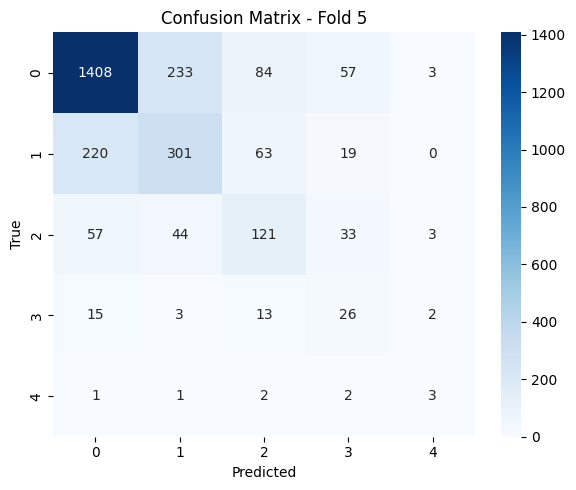

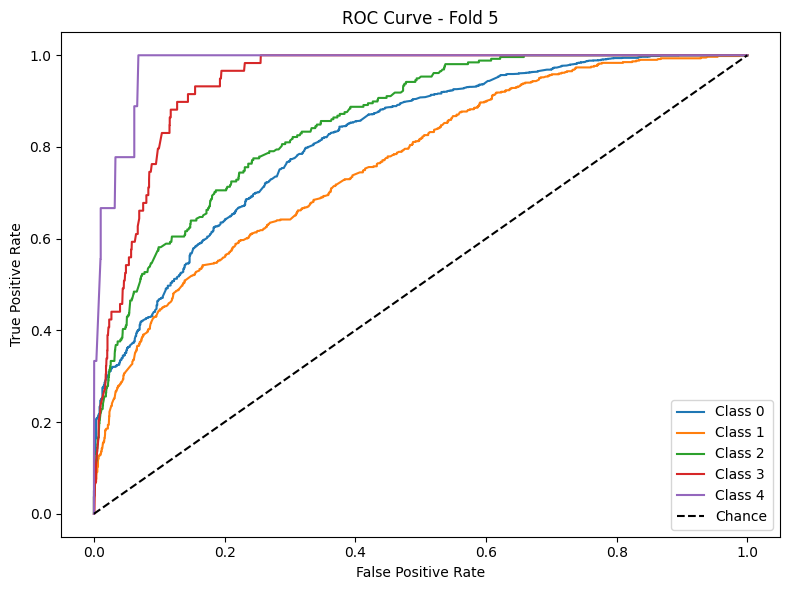


Average Accuracy: 0.6753
Average F1 Macro: 0.4421
Average AUC: 0.8695

Feature Importances:
video                                  0.244891
assignment                             0.102782
exercise_langugage_binary_mean_1       0.063309
exercise_correct_sum_1                 0.059011
encoded_field_sum                      0.043812
exercise_perc_real_score_mean_1        0.040856
certificate                            0.037776
exercise_count                         0.031537
duration_days                          0.030858
exercise_context_sum_1                 0.028981
exercise_id_count_1                    0.027764
chapter_count                          0.027186
exercise_num_problem_sum_1             0.025540
num_prerequisites                      0.021504
exam                                   0.020211
video_count                            0.020109
user_month                             0.017721
exercise_correct_mean_1                0.016679
exercise_attempts_sum_mean_1           0.01

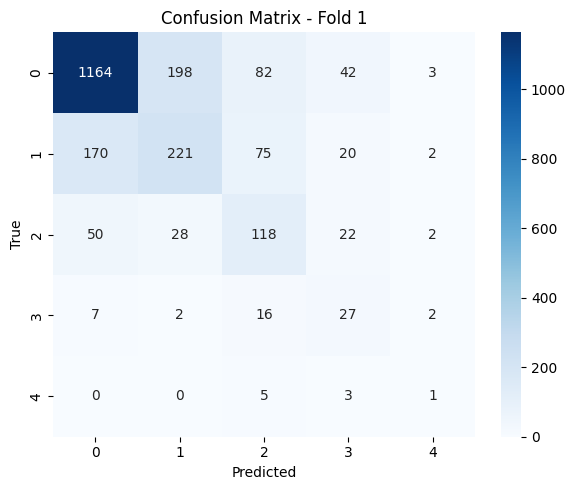

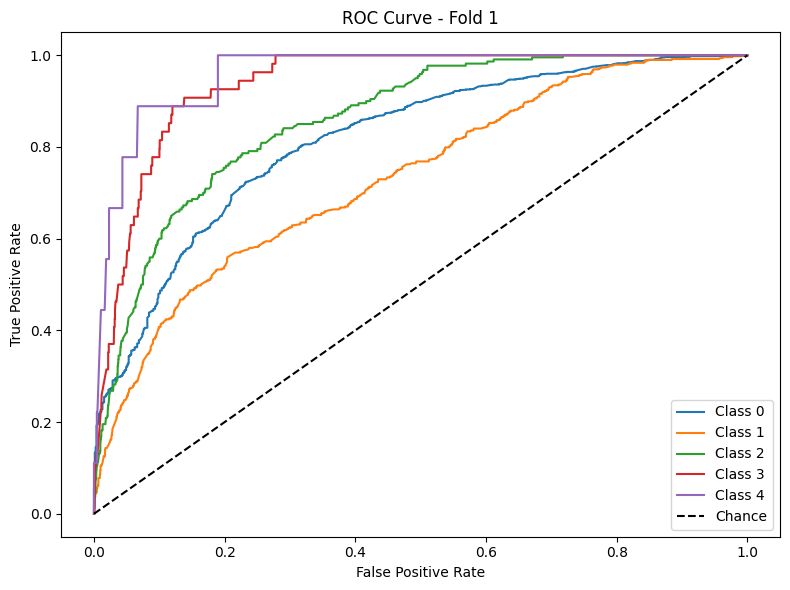


--- Processing Fold 2 ---

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.76      0.79      1489
           1       0.47      0.48      0.48       489
           2       0.36      0.44      0.40       219
           3       0.24      0.45      0.31        55
           4       0.20      0.38      0.26         8

    accuracy                           0.66      2260
   macro avg       0.42      0.50      0.45      2260
weighted avg       0.69      0.66      0.67      2260



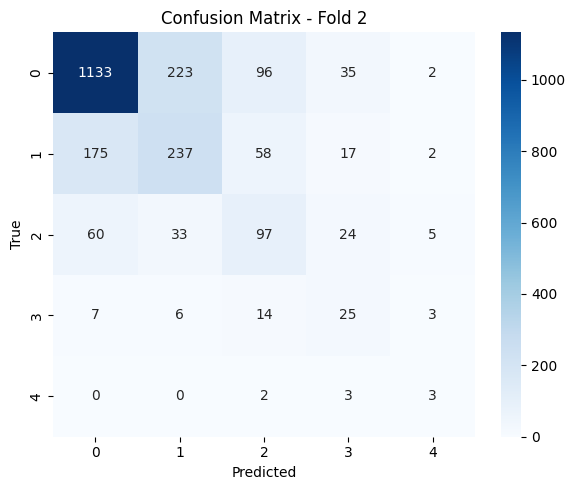

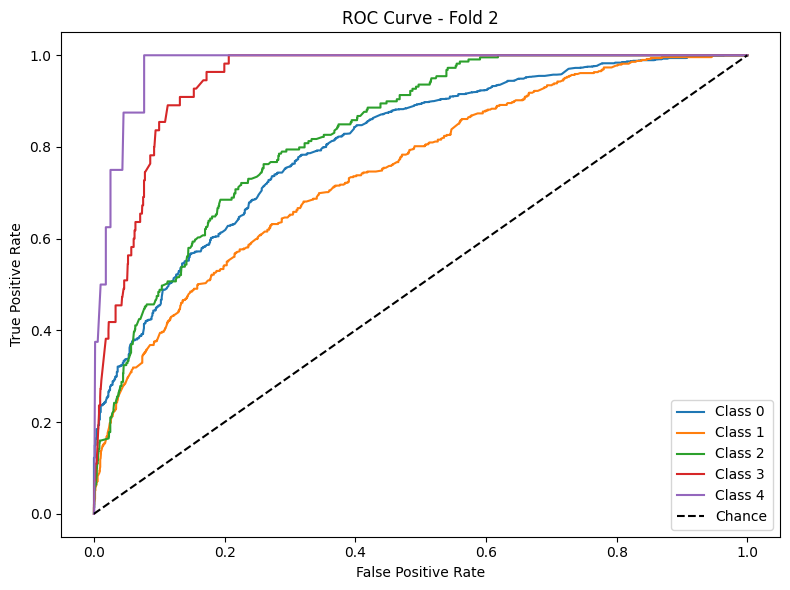


--- Processing Fold 3 ---

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.77      0.80      1489
           1       0.46      0.44      0.45       489
           2       0.41      0.56      0.47       219
           3       0.22      0.41      0.28        54
           4       0.44      0.50      0.47         8

    accuracy                           0.67      2259
   macro avg       0.47      0.53      0.49      2259
weighted avg       0.69      0.67      0.68      2259



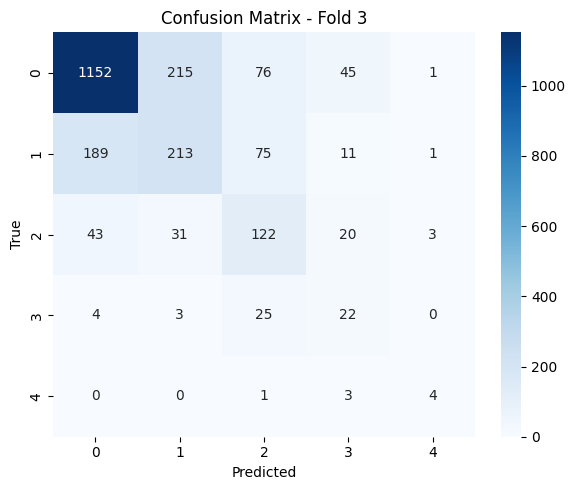

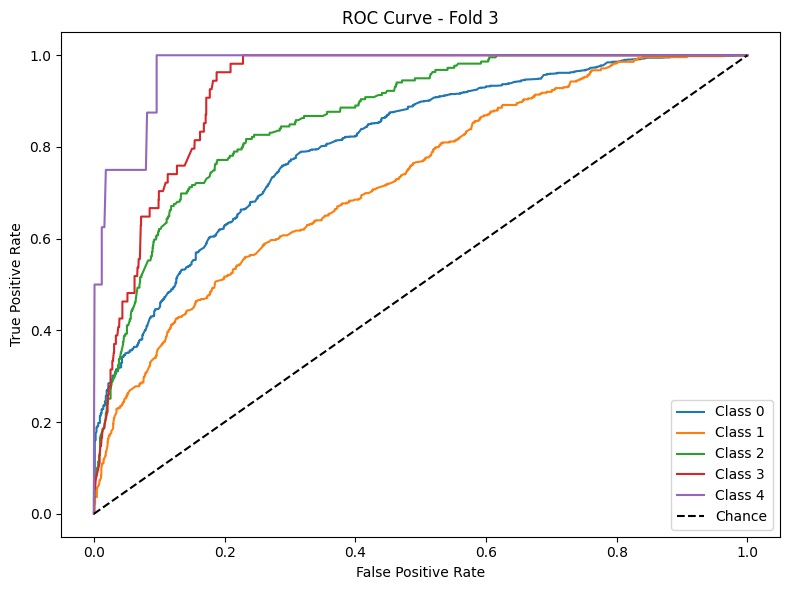


--- Processing Fold 4 ---

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80      1489
           1       0.47      0.45      0.46       489
           2       0.42      0.50      0.46       219
           3       0.29      0.52      0.37        54
           4       0.33      0.50      0.40         8

    accuracy                           0.67      2259
   macro avg       0.47      0.55      0.50      2259
weighted avg       0.69      0.67      0.68      2259



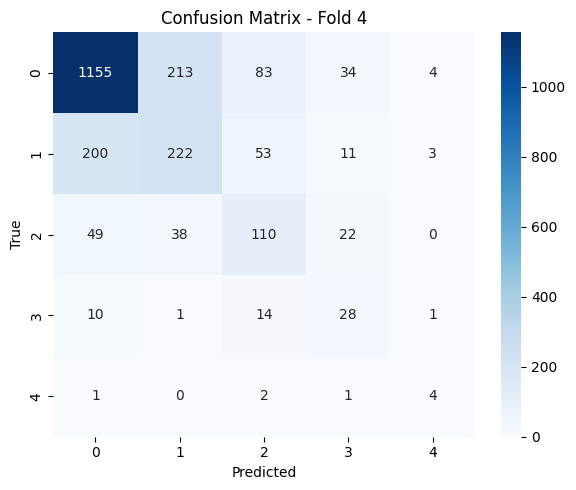

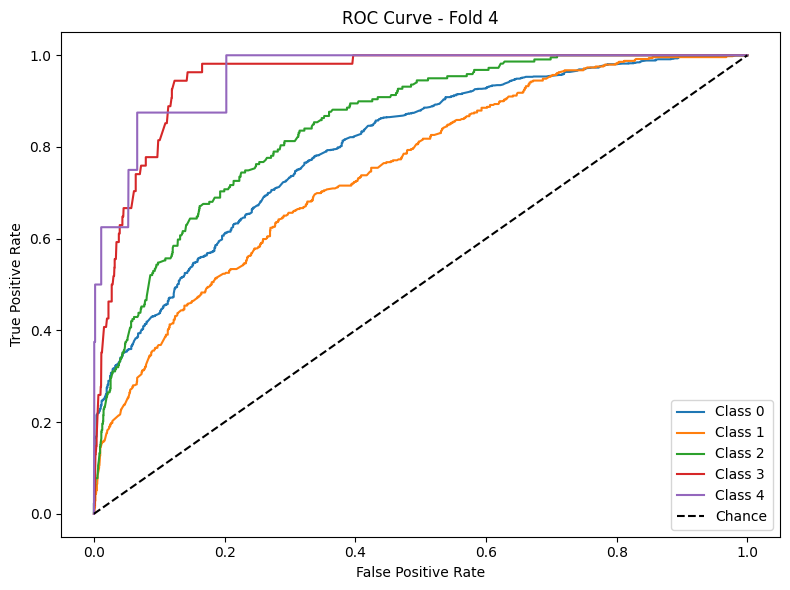


--- Processing Fold 5 ---

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.78      0.81      1490
           1       0.49      0.48      0.49       488
           2       0.37      0.51      0.43       219
           3       0.16      0.26      0.20        54
           4       0.08      0.12      0.10         8

    accuracy                           0.67      2259
   macro avg       0.39      0.43      0.40      2259
weighted avg       0.70      0.67      0.69      2259



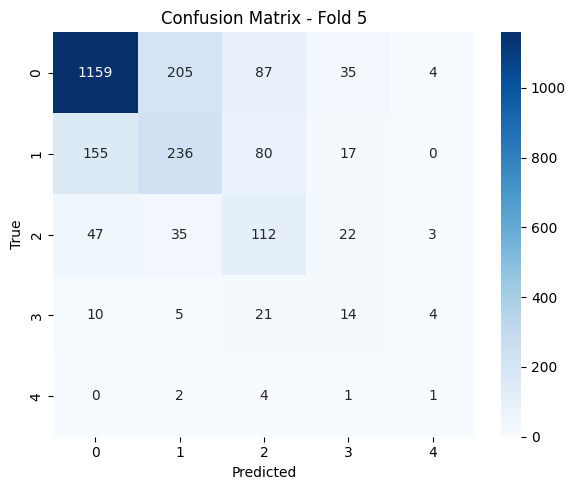

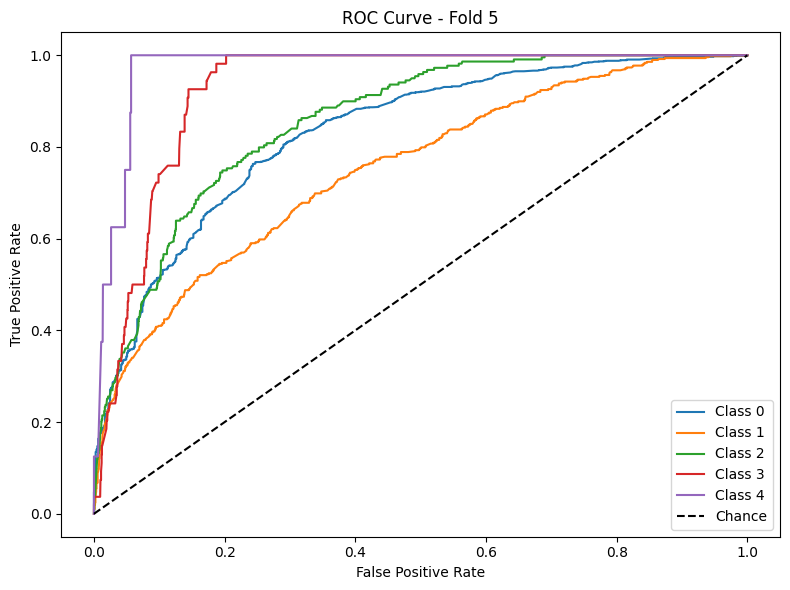


Average Accuracy: 0.6710
Average F1 Macro: 0.4557
Average AUC: 0.8625

Feature Importances:
video                                  0.148516
assignment                             0.100218
exam                                   0.050671
exercise_context_sum_1                 0.045212
chapter_count                          0.034720
certificate                            0.029833
num_prerequisites                      0.027531
exercise_id_count_1                    0.026709
exercise_count                         0.023927
exercise_correct_sum_1                 0.023476
encoded_field_sum                      0.023182
exercise_perc_real_score_mean_2        0.021620
video_count                            0.021323
exercise_correct_mean_2                0.020300
exercise_hour_entropy_1                0.019566
duration_days                          0.019071
exercise_num_problem_sum_1             0.018848
exercise_diff_mean_1                   0.017507
exercise_correct_sum_2                 0.01

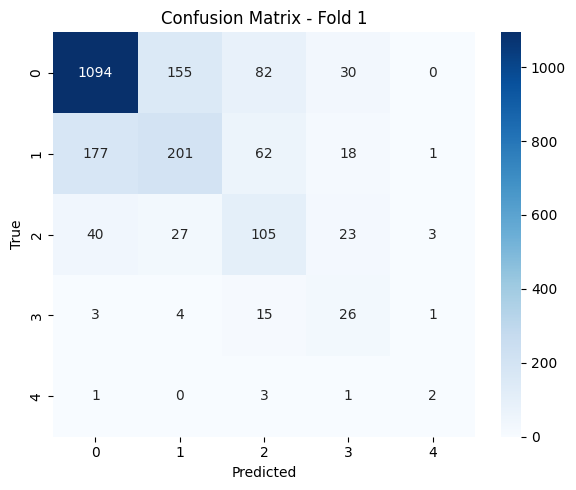

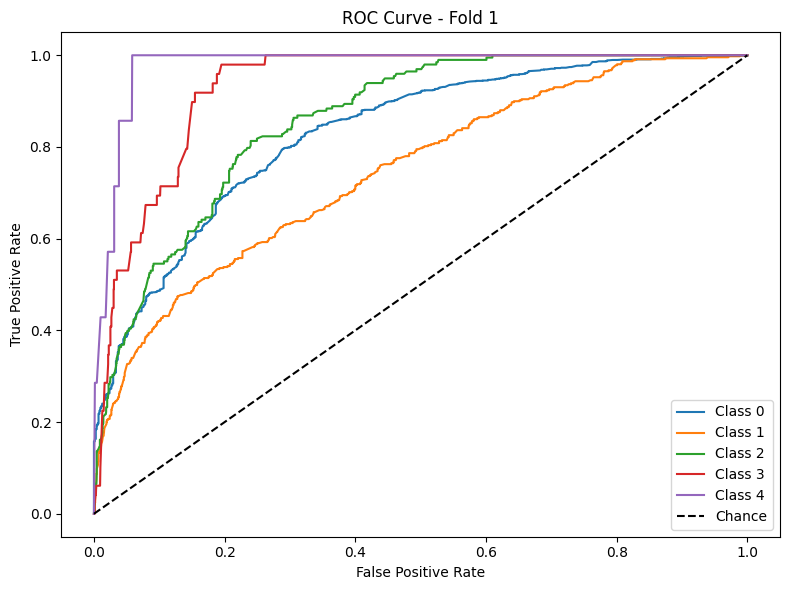


--- Processing Fold 2 ---

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81      1360
           1       0.48      0.45      0.46       459
           2       0.42      0.54      0.47       198
           3       0.29      0.50      0.37        50
           4       0.00      0.00      0.00         7

    accuracy                           0.68      2074
   macro avg       0.40      0.46      0.42      2074
weighted avg       0.70      0.68      0.69      2074



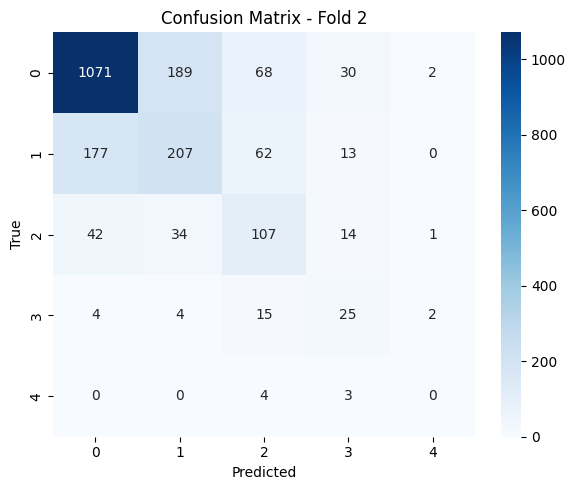

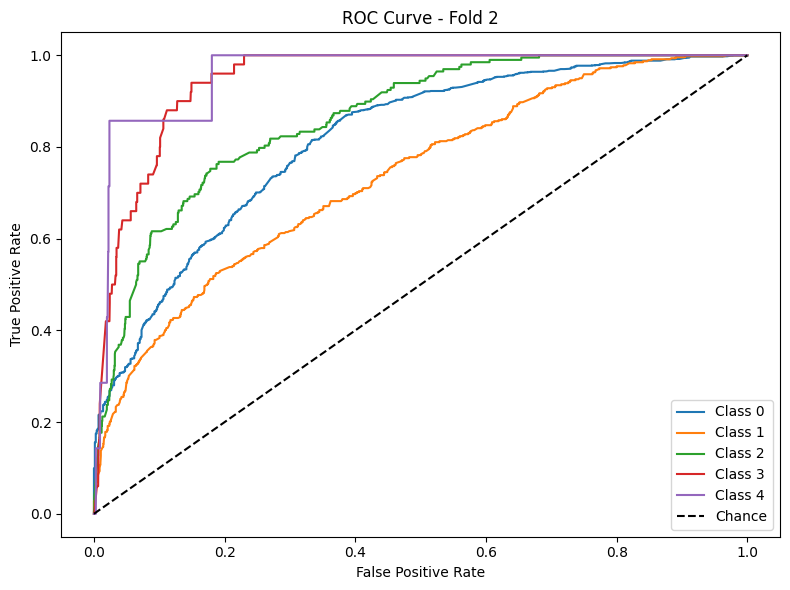


--- Processing Fold 3 ---

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80      1360
           1       0.47      0.46      0.46       459
           2       0.37      0.43      0.40       198
           3       0.24      0.44      0.31        50
           4       0.20      0.29      0.24         7

    accuracy                           0.67      2074
   macro avg       0.42      0.48      0.44      2074
weighted avg       0.69      0.67      0.68      2074



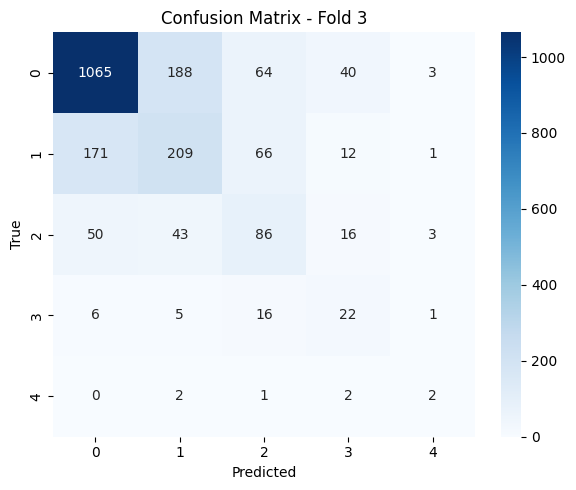

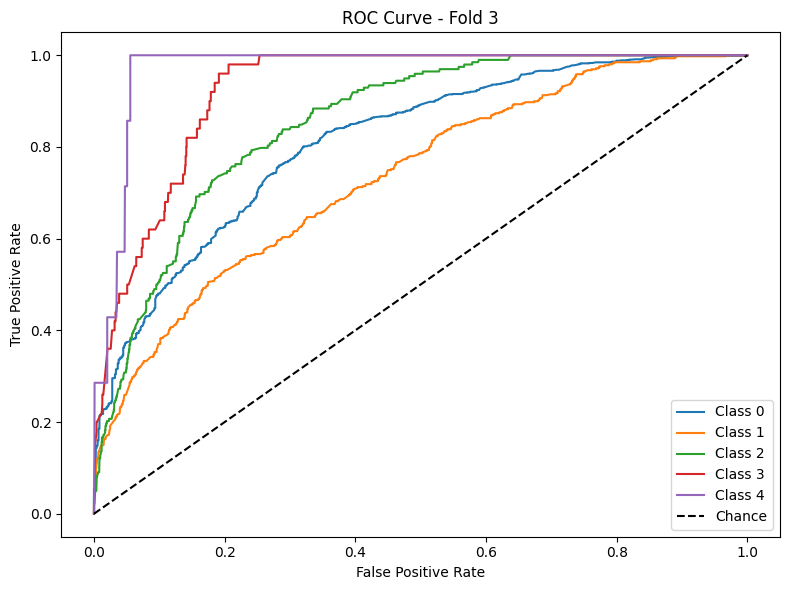


--- Processing Fold 4 ---

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.80      1360
           1       0.47      0.46      0.46       459
           2       0.42      0.46      0.44       198
           3       0.29      0.48      0.36        50
           4       0.14      0.29      0.19         7

    accuracy                           0.68      2074
   macro avg       0.43      0.50      0.45      2074
weighted avg       0.69      0.68      0.68      2074



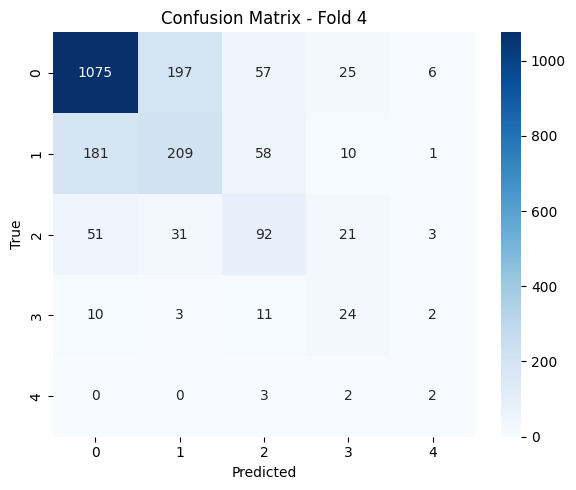

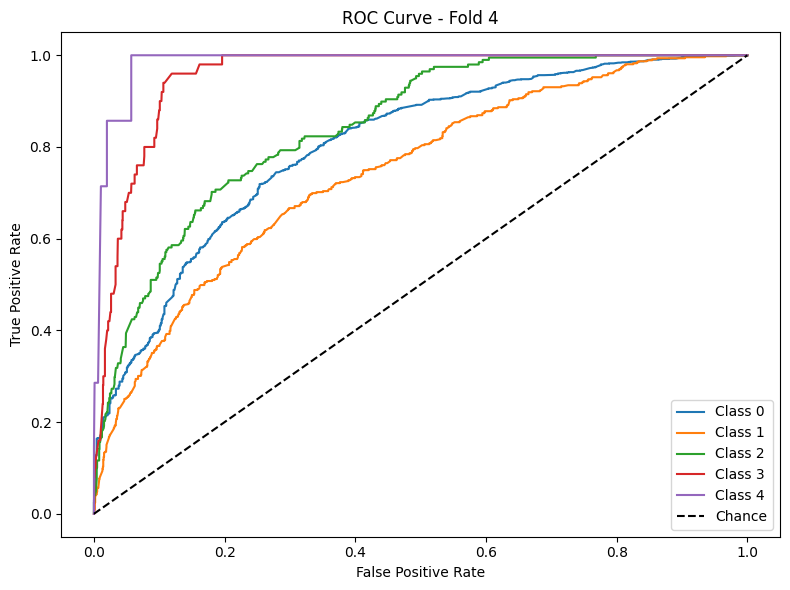


--- Processing Fold 5 ---

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.76      0.79      1360
           1       0.46      0.46      0.46       460
           2       0.38      0.49      0.43       197
           3       0.23      0.43      0.30        49
           4       0.08      0.14      0.10         7

    accuracy                           0.66      2073
   macro avg       0.39      0.46      0.42      2073
weighted avg       0.69      0.66      0.67      2073



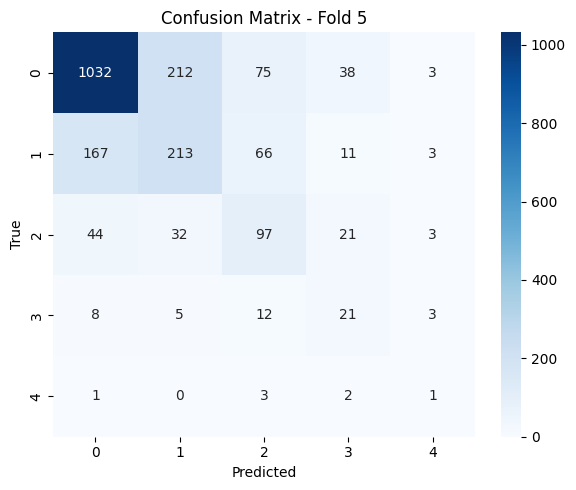

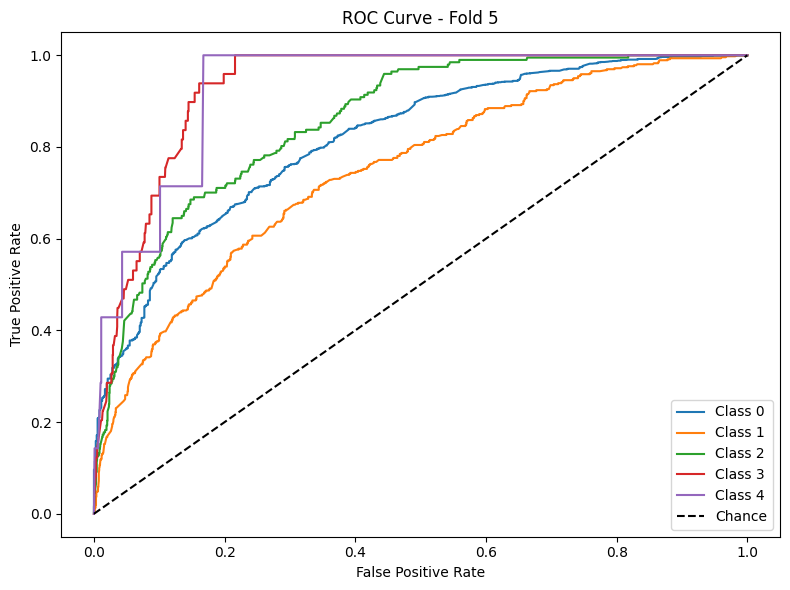


Average Accuracy: 0.6739
Average F1 Macro: 0.4418
Average AUC: 0.8630

Feature Importances:
video                                  0.152846
assignment                             0.095779
exam                                   0.042487
chapter_count                          0.040169
encoded_field_sum                      0.029526
certificate                            0.029438
num_prerequisites                      0.027999
exercise_context_sum_1                 0.027461
exercise_num_problem_sum_2             0.026212
exercise_correct_sum_1                 0.023712
duration_days                          0.022445
user_month                             0.018677
video_count                            0.018224
exercise_count                         0.017459
exercise_hour_entropy_3                0.017351
exercise_perc_real_score_mean_2        0.016248
exercise_num_problem_sum_1             0.015117
exercise_id_count_1                    0.014958
exercise_correct_sum_2                 0.01

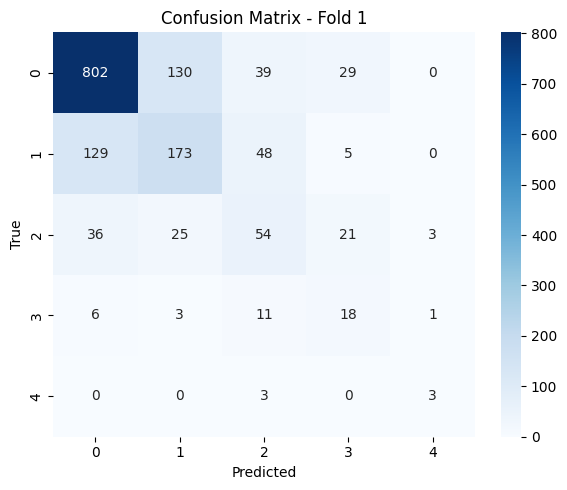

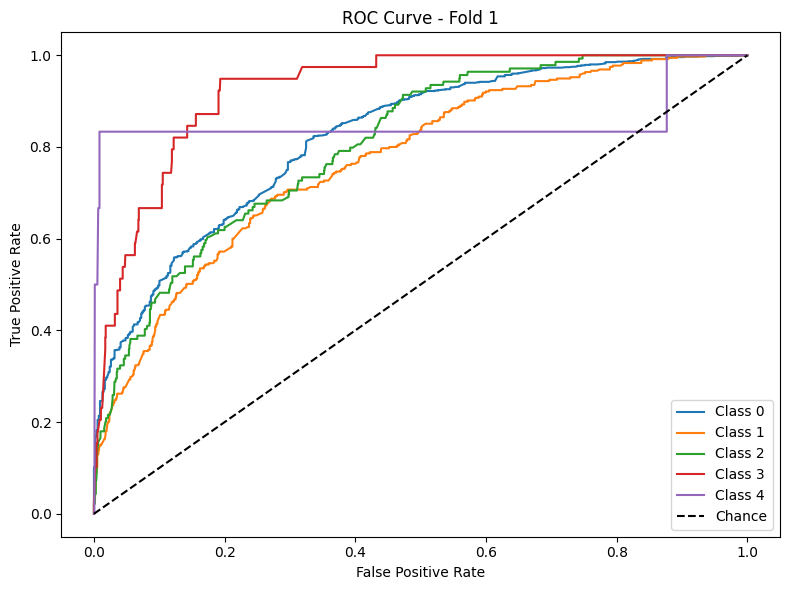


--- Processing Fold 2 ---

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.77      0.80      1000
           1       0.51      0.52      0.52       355
           2       0.50      0.53      0.52       139
           3       0.25      0.45      0.32        40
           4       0.00      0.00      0.00         5

    accuracy                           0.68      1539
   macro avg       0.42      0.46      0.43      1539
weighted avg       0.70      0.68      0.69      1539



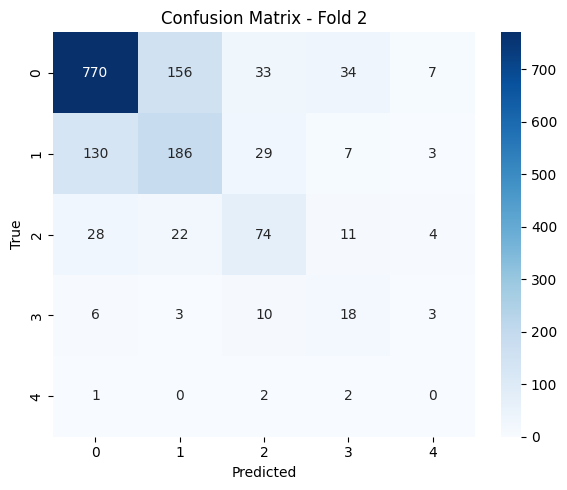

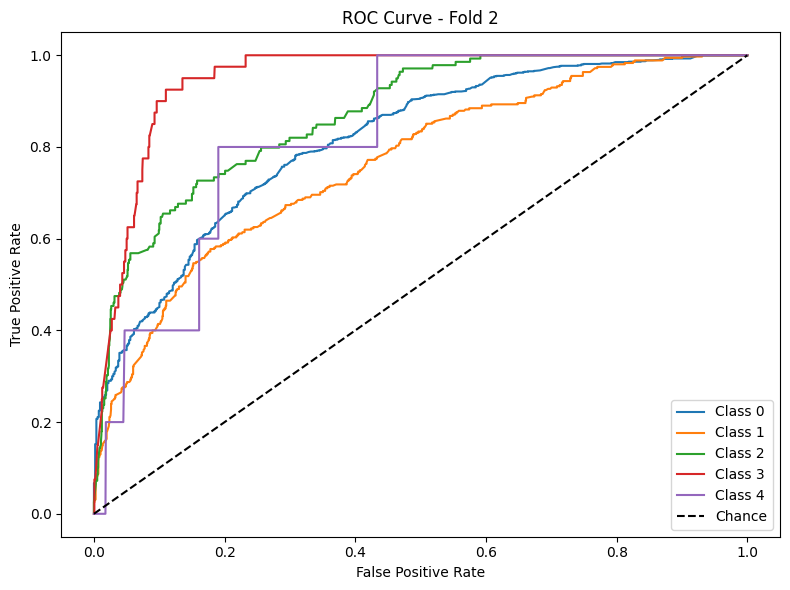


--- Processing Fold 3 ---

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.81       999
           1       0.54      0.53      0.53       355
           2       0.48      0.53      0.51       139
           3       0.29      0.47      0.36        40
           4       0.00      0.00      0.00         6

    accuracy                           0.70      1539
   macro avg       0.43      0.47      0.44      1539
weighted avg       0.71      0.70      0.71      1539



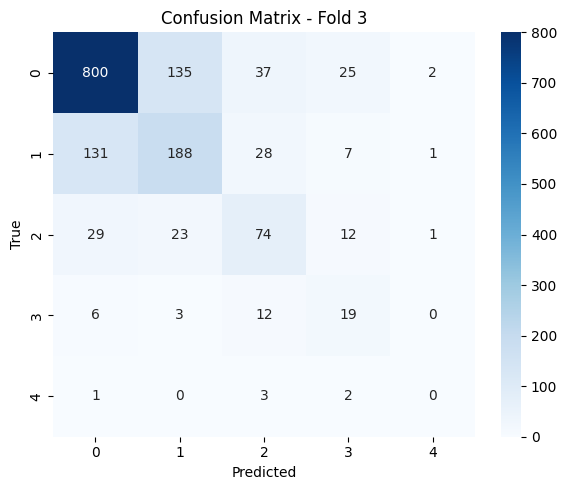

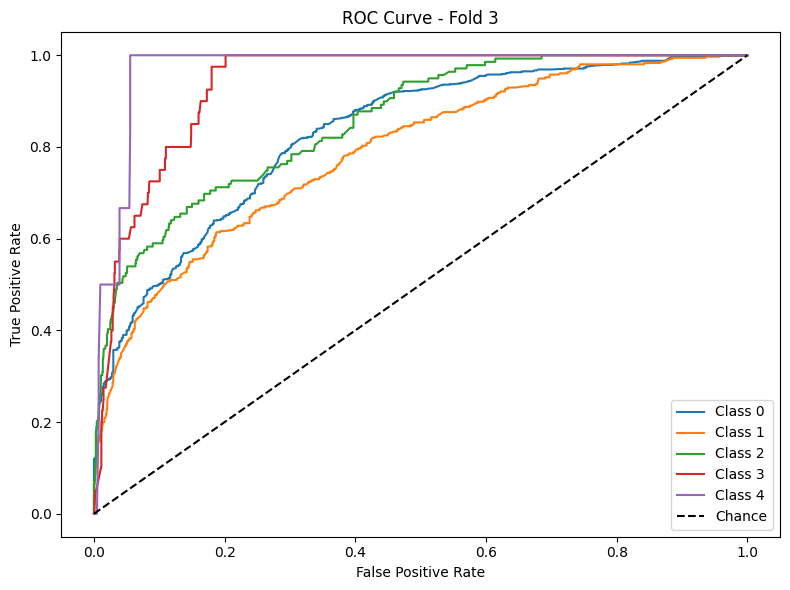


--- Processing Fold 4 ---

Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.82       999
           1       0.51      0.46      0.49       356
           2       0.46      0.49      0.47       138
           3       0.30      0.49      0.37        39
           4       0.21      0.67      0.32         6

    accuracy                           0.69      1538
   macro avg       0.46      0.58      0.49      1538
weighted avg       0.70      0.69      0.70      1538



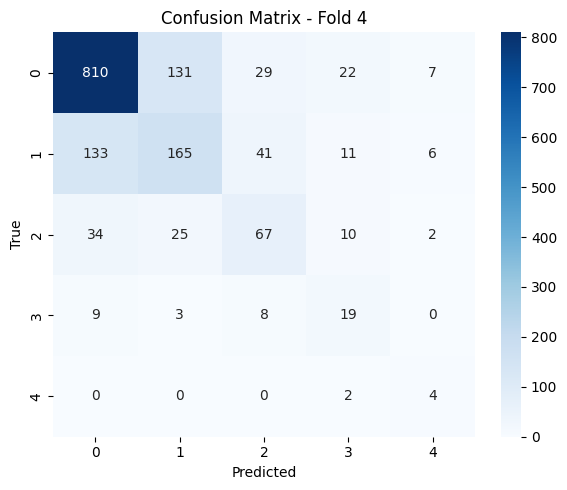

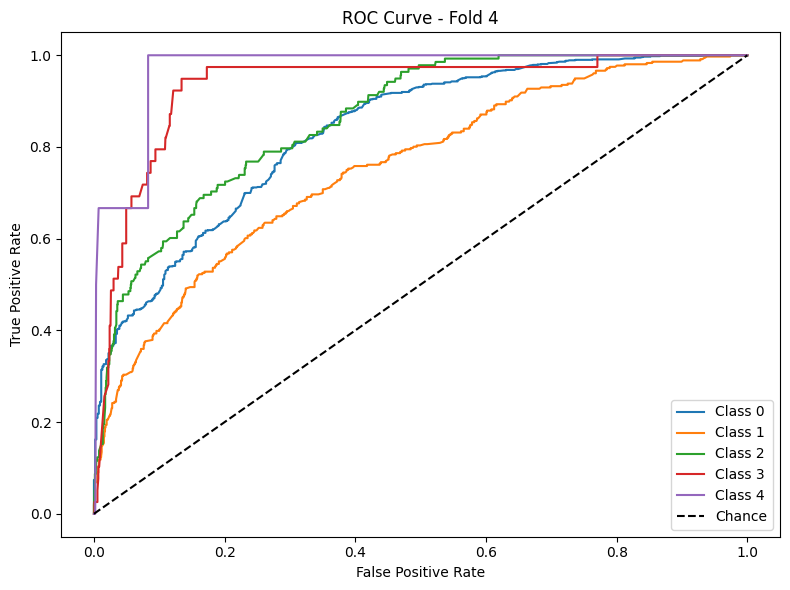


--- Processing Fold 5 ---

Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82       999
           1       0.53      0.52      0.52       356
           2       0.40      0.46      0.43       138
           3       0.32      0.54      0.40        39
           4       0.00      0.00      0.00         6

    accuracy                           0.69      1538
   macro avg       0.42      0.46      0.43      1538
weighted avg       0.71      0.69      0.70      1538



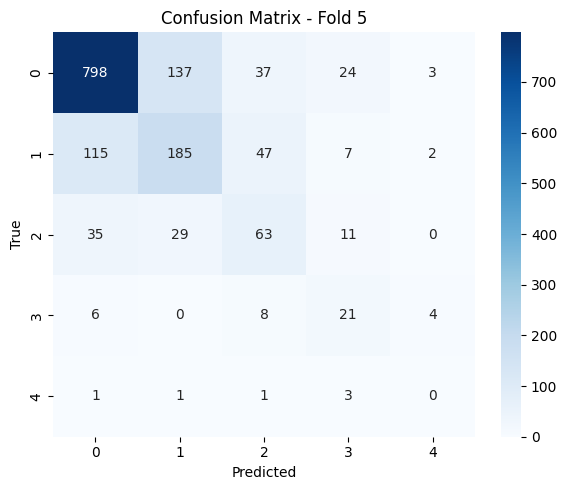

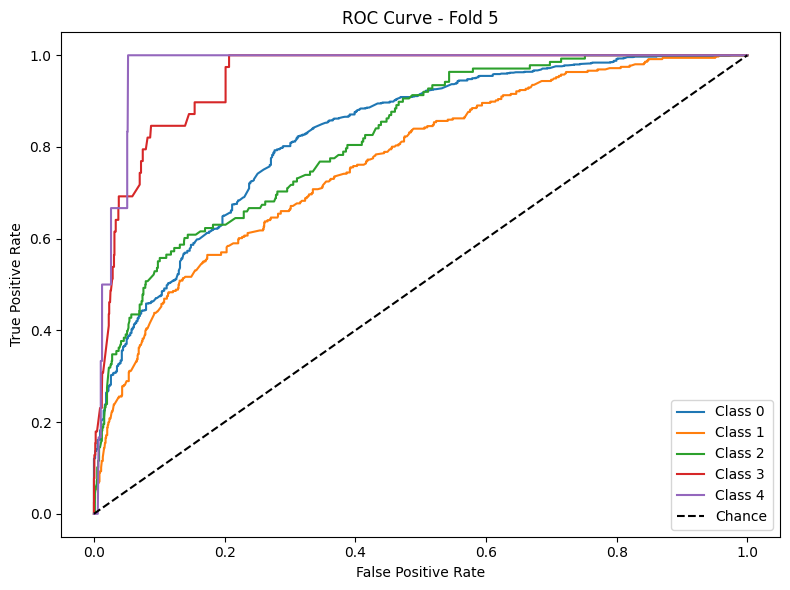


Average Accuracy: 0.6904
Average F1 Macro: 0.4585
Average AUC: 0.8587

Feature Importances:
assignment                             0.111865
video                                  0.082021
certificate                            0.035940
chapter_count                          0.033768
encoded_field_sum                      0.029737
exercise_correct_sum_1                 0.028381
user_month                             0.019558
video_count                            0.019197
num_prerequisites                      0.019060
total_negative4                        0.018468
duration_days                          0.018227
exercise_count                         0.017921
exercise_id_count_1                    0.017273
exercise_context_sum_2                 0.016874
exercise_context_sum_1                 0.016859
exercise_correct_sum_4                 0.016784
exercise_attempts_sum_mean_4           0.016438
exercise_id_count_2                    0.015744
exercise_correct_sum_2                 0.01

In [9]:
phase_paths = [f"/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = True
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics



Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       568
           1       0.43      0.29      0.34        63
           2       0.42      0.35      0.38        43
           3       0.25      0.07      0.11        15
           4       0.00      0.00      0.00         9

    accuracy                           0.82       698
   macro avg       0.40      0.33      0.35       698
weighted avg       0.79      0.82      0.80       698



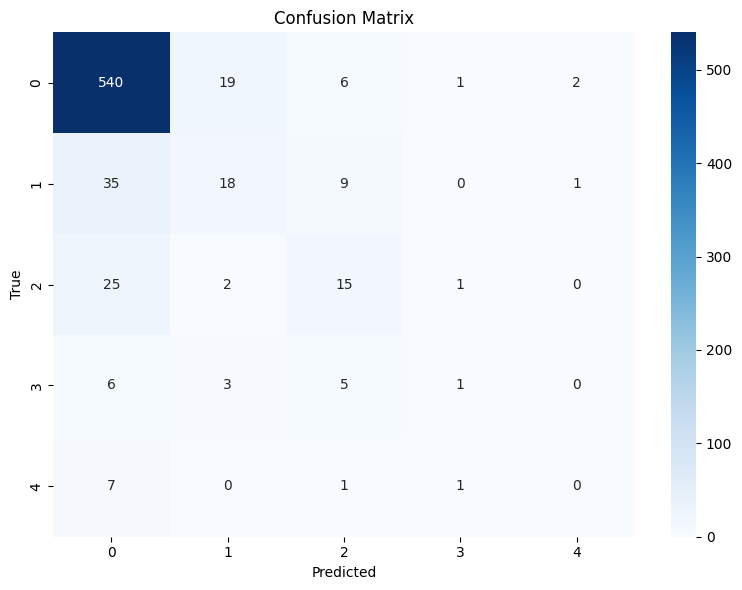


Test AUC (macro-average, OVR): 0.8549


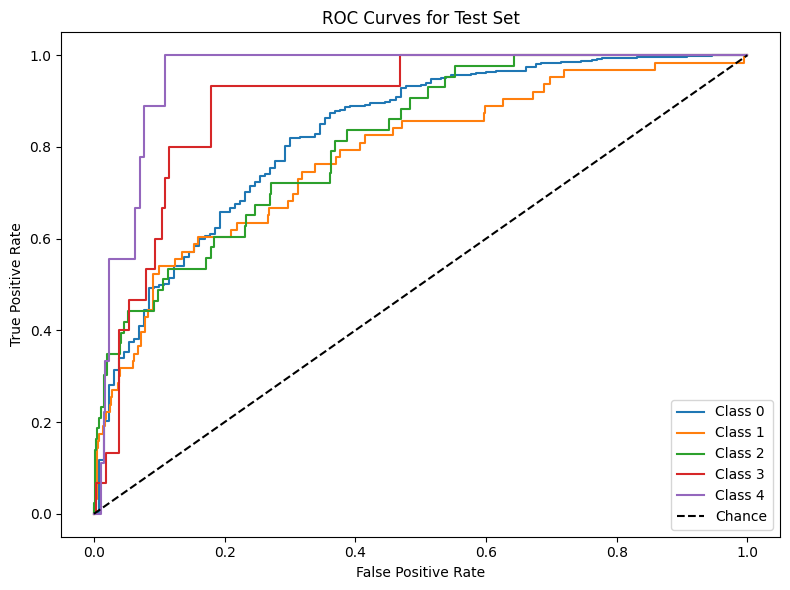


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       544
           1       0.27      0.25      0.26        59
           2       0.38      0.29      0.32        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.79       668
   macro avg       0.30      0.29      0.30       668
weighted avg       0.76      0.79      0.78       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


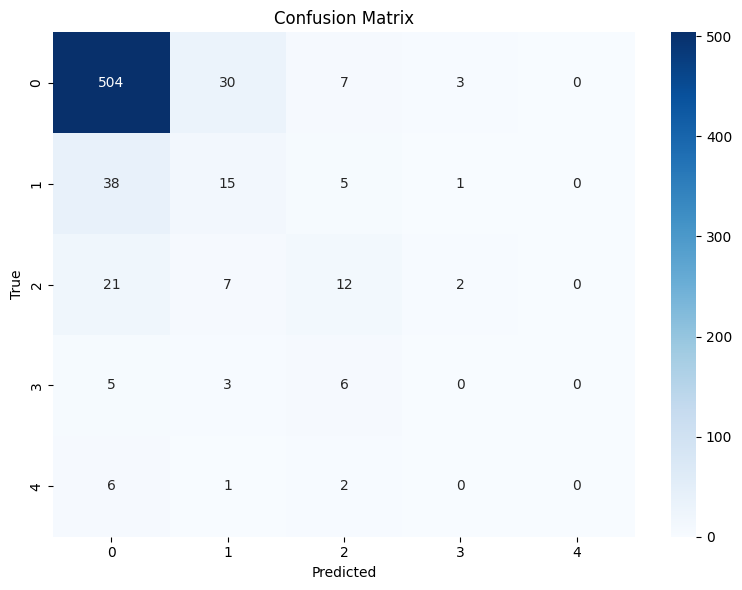


Test AUC (macro-average, OVR): 0.8137


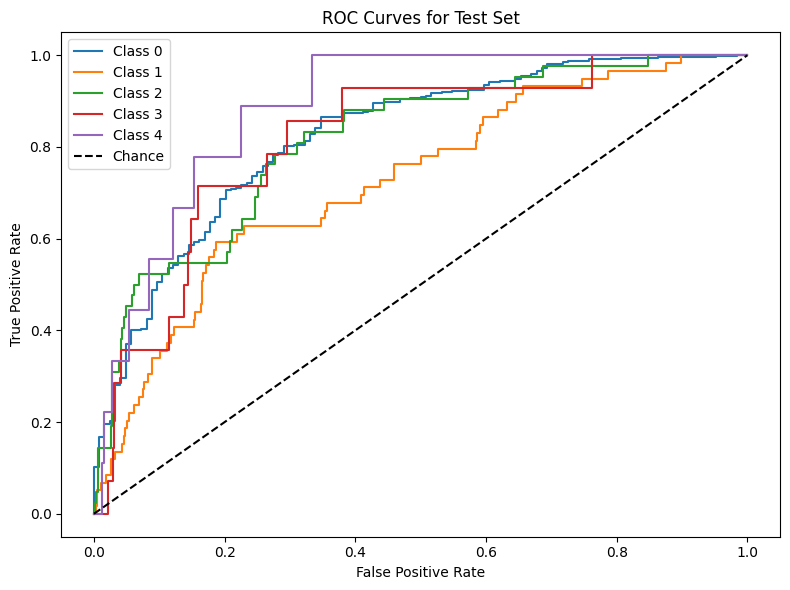


Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.97      0.91       455
           1       0.42      0.19      0.26        52
           2       0.20      0.03      0.06        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.81       554
   macro avg       0.29      0.24      0.25       554
weighted avg       0.75      0.81      0.77       554



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


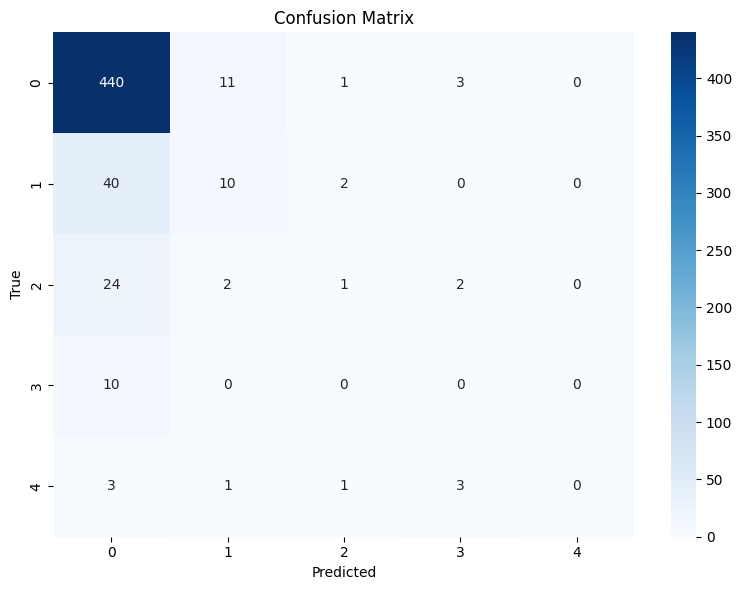


Test AUC (macro-average, OVR): 0.7996


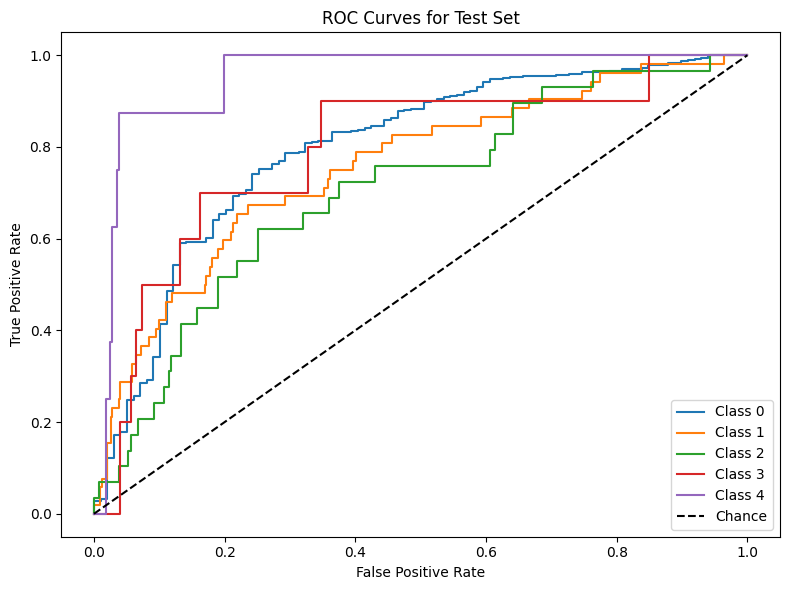


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       395
           1       0.14      0.17      0.16        40
           2       0.21      0.21      0.21        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.75       477
   macro avg       0.25      0.25      0.25       477
weighted avg       0.75      0.75      0.75       477



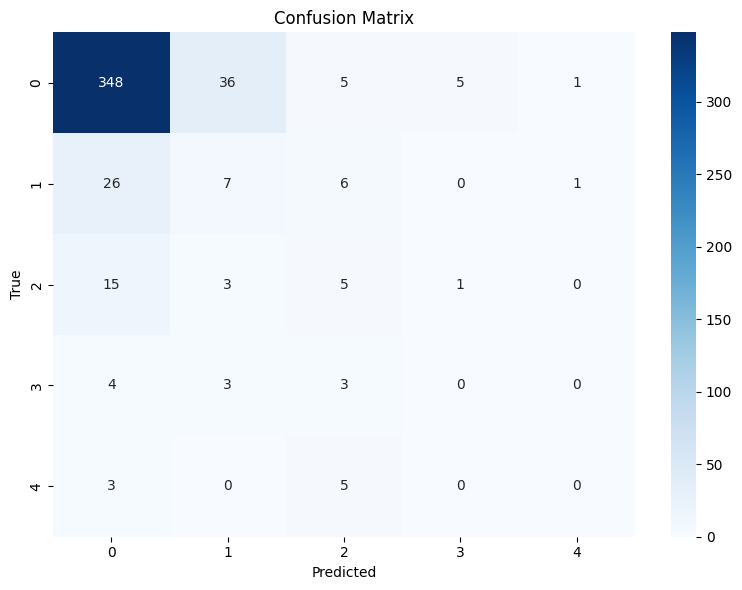


Test AUC (macro-average, OVR): 0.7388


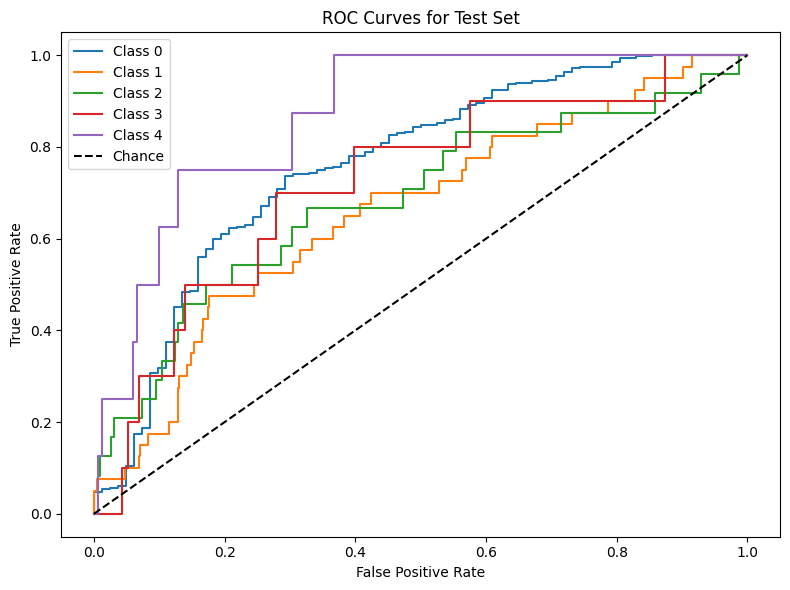

In [10]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/filtered-final-data/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)